In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd

import unicodedata
import re
import json

import acquire

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup
import prepare

# `Acquire` Data.

In [2]:
df = acquire.get_fifa_data()

/var/folders/dc/8rtfvpyj2mb6mqbnfkf5dl400000gn/T/ipykernel_7012/1900469672.py:1: DtypeWarning: Columns (81,85,104) have mixed types.Specify dtype option on import or set low_memory=False.
  df = acquire.get_fifa_data()


# `Explore` And `Prep` Data

In [3]:
df

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,...,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png,2022,172947000.0
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,...,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,2022,172947000.0
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,...,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png,2022,172947000.0
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,...,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png,2022,172947000.0
4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,...,69+3,75+3,21+3,https://cdn.sofifa.net/players/192/985/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png,2022,172947000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142074,220806,https://sofifa.com/player/220806/ellis-redman/...,E. Redman,Ellis Redman,CB,41,61,20000.0,2000.0,17,...,41,40,10,https://cdn.sofifa.net/players/220/806/15_120.png,https://cdn.sofifa.net/teams/112254/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/gb-wls.png,2015,210927000.0
142075,225509,https://sofifa.com/player/225509/aaron-collins...,A. Collins,Aaron Graham John Collins,ST,41,50,30000.0,2000.0,17,...,31,32,14,https://cdn.sofifa.net/players/225/509/15_120.png,https://cdn.sofifa.net/teams/112254/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/gb-wls.png,2015,210927000.0
142076,201197,https://sofifa.com/player/201197/paul-tisdale/...,P. Tisdale,Paul Tisdale,"CM, CAM",40,40,NaN,2000.0,41,...,33,34,10,https://cdn.sofifa.net/players/201/197/15_120.png,https://cdn.sofifa.net/teams/143/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/mt.png,2015,210927000.0
142077,217591,https://sofifa.com/player/217591/piotr-zemlo/1...,P. Żemło,Piotr Żemło,"LM, LB",40,50,15000.0,2000.0,18,...,53-3,51-1,12,https://cdn.sofifa.net/players/217/591/15_120.png,https://cdn.sofifa.net/teams/1873/60.png,https://cdn.sofifa.net/flags/pl.png,NaN,https://cdn.sofifa.net/flags/pl.png,2015,210927000.0


In [4]:
#add 0 values to non goal keeper players
df['goalkeeping_speed'].fillna("0", inplace = True)

In [5]:
#forces dataframe to show every columns
pd.set_option('display.max_columns', None)
df

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96.0,20,35,24,6,11,15,14,8,0,89+3,89+3,89+3,92.0,93,93,93,92.0,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png,2022,172947000.0
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88.0,35,42,19,15,6,12,8,10,0,90+2,90+2,90+2,85.0,88,88,88,85.0,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,2022,172947000.0
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95.0,24,32,24,7,11,15,14,11,0,90+1,90+1,90+1,88.0,89,89,89,88.0,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,h

# Columns That Have Null Values
- plan:
    adress and acess null values

In [6]:
na = df.isna().sum() > 0
na[na]

value_eur                    True
wage_eur                     True
club_team_id                 True
club_name                    True
league_name                  True
league_level                 True
club_position                True
club_jersey_number           True
club_loaned_from             True
club_joined                  True
club_contract_valid_until    True
nation_team_id               True
nation_position              True
nation_jersey_number         True
release_clause_eur           True
player_tags                  True
player_traits                True
pace                         True
shooting                     True
passing                      True
dribbling                    True
defending                    True
physic                       True
mentality_composure          True
lw                           True
rw                           True
club_logo_url                True
club_flag_url                True
nation_logo_url              True
dtype: bool

# `value_eur`,`wage_eur`, & `club_team_id`.

In [7]:
df[df.value_eur.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
147,184087,https://sofifa.com/player/184087/toby-alderwei...,T. Alderweireld,Toby Alderweireld,CB,83,83,NaN,NaN,32,1989-03-02,186,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,RCB,2.0,Right,3,2,3,Medium/Medium,Normal (185+),Yes,NaN,NaN,Long Passer (AI),58.0,55.0,70.0,67.0,86.0,77.0,64,45,81,77,38,62,63,59,81,75,55,60,54,85,62,78,81,76,77,58,79,85,52,62,58,86.0,87,87,84,16,6,14,16,14,0,65+3,65+3,65+3,63.0,65,65,65,63.0,66+3,66+3,66+3,66+3,73+3,73+3,73+3,66+3,77+3,81+2,81+2,81+2,77+3,78+3,82+1,82+1,82+1,78+3,21+3,https://cdn.sofifa.net/players/184/087/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png,2022,172947000.0
416,197242,https://sofifa.com/player/197242/grzegorz-kryc...,G. Krychowiak,Grzegorz Krychowiak,"CDM, CM",80,80,NaN,NaN,31,1990-01-29,187,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,Poland,1353.0,CDM,10.0,Right,3,3,3,High/High,Normal (185+),No,NaN,NaN,"Long Passer (AI), Long Shot Taker (AI)",68.0,76.0,72.0,72.0,75.0,81.0,63,72,75,78,75,70,54,62,81,79,67,69,59,80,53,82,74,78,83,78,80,77,72,69,78,80.0,75,76,72,15,14,8,6,7,0,75+3,75+3,75+3,72.0,74,74,74,72.0,74+3,74+3,74+3,73+3,76+3,76+3,76+3,73+3,74+3,78+2,78+2,78+2,74+3,74+3,77+3,77+3,77+3,74+3,18+3,https://cdn.sofifa.net/players/197/242/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,2022,172947000.0
694,187607,https://sofifa.com/player/187607/artem-dzyuba/...,A. Dzyuba,Artem Dzyuba,ST,78,78,NaN,NaN,32,1988-08-22,196,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,ST,22.0,Right,3,3,2,Medium/Low,Normal (185+),No,NaN,"#Aerial Threat, #Strength",Leadership,65.0,78.0,69.0,71.0,29.0,86.0,61,81,87,77,74,73,66,60,57,77,63,66,55,75,35,79,65,78,94,69,80,30,81,77,75,79.0,25,17,21,15,12,11,11,8,0,78,78,78,73.0,76,76,76,73.0,74+2,74+2,74+2,73+2,69+2,69+2,69+2,73+2,53+2,54+2,54+2,54+2,53+2,50+2,50+2,50+2,50+2,50+2,18+2,https://cdn.sofifa.net/players/187/607/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1357/60.png,https://cdn.sofifa.net/flags/ru.png,2022,172947000.0
926,200094,https://sofifa.com/player/200094/magomed-ozdoe...,M. Ozdoev,Magomed Ozdoev,"CDM, CM",77,78,NaN,NaN,28,1992-11-05,184,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,RDM,7.0,Right,3,3,1,Medium/High,Normal (170-185),No,NaN,NaN,Long Passer (AI),75.0,70.0,72.0,76.0,73.0,76.0,65,69,57,78,45,77,58,56,76,76,73,77,80,73,74,81,67,78,75,74,77,75,68,74,54,72.0,73,76,73,11,8,16,16,15,0,71+2,71+2,71+2,73.0,74,74,74,73.0,75+2,75+2,75+2,74+2,75+2,75+2,75+2,74+2,74+2,76+2,76+2,76+2,74+2,73+2,73+2,73+2,73+2,73+2

`Takeaways:`
- we might have to consider removing these players because they would corrupt our data considering their wage information is missing and would not add any value to our model.

In [8]:
df[df.wage_eur.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
147,184087,https://sofifa.com/player/184087/toby-alderwei...,T. Alderweireld,Toby Alderweireld,CB,83,83,NaN,NaN,32,1989-03-02,186,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,RCB,2.0,Right,3,2,3,Medium/Medium,Normal (185+),Yes,NaN,NaN,Long Passer (AI),58.0,55.0,70.0,67.0,86.0,77.0,64,45,81,77,38,62,63,59,81,75,55,60,54,85,62,78,81,76,77,58,79,85,52,62,58,86.0,87,87,84,16,6,14,16,14,0,65+3,65+3,65+3,63.0,65,65,65,63.0,66+3,66+3,66+3,66+3,73+3,73+3,73+3,66+3,77+3,81+2,81+2,81+2,77+3,78+3,82+1,82+1,82+1,78+3,21+3,https://cdn.sofifa.net/players/184/087/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png,2022,172947000.0
416,197242,https://sofifa.com/player/197242/grzegorz-kryc...,G. Krychowiak,Grzegorz Krychowiak,"CDM, CM",80,80,NaN,NaN,31,1990-01-29,187,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,Poland,1353.0,CDM,10.0,Right,3,3,3,High/High,Normal (185+),No,NaN,NaN,"Long Passer (AI), Long Shot Taker (AI)",68.0,76.0,72.0,72.0,75.0,81.0,63,72,75,78,75,70,54,62,81,79,67,69,59,80,53,82,74,78,83,78,80,77,72,69,78,80.0,75,76,72,15,14,8,6,7,0,75+3,75+3,75+3,72.0,74,74,74,72.0,74+3,74+3,74+3,73+3,76+3,76+3,76+3,73+3,74+3,78+2,78+2,78+2,74+3,74+3,77+3,77+3,77+3,74+3,18+3,https://cdn.sofifa.net/players/197/242/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,2022,172947000.0
694,187607,https://sofifa.com/player/187607/artem-dzyuba/...,A. Dzyuba,Artem Dzyuba,ST,78,78,NaN,NaN,32,1988-08-22,196,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,ST,22.0,Right,3,3,2,Medium/Low,Normal (185+),No,NaN,"#Aerial Threat, #Strength",Leadership,65.0,78.0,69.0,71.0,29.0,86.0,61,81,87,77,74,73,66,60,57,77,63,66,55,75,35,79,65,78,94,69,80,30,81,77,75,79.0,25,17,21,15,12,11,11,8,0,78,78,78,73.0,76,76,76,73.0,74+2,74+2,74+2,73+2,69+2,69+2,69+2,73+2,53+2,54+2,54+2,54+2,53+2,50+2,50+2,50+2,50+2,50+2,18+2,https://cdn.sofifa.net/players/187/607/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1357/60.png,https://cdn.sofifa.net/flags/ru.png,2022,172947000.0
926,200094,https://sofifa.com/player/200094/magomed-ozdoe...,M. Ozdoev,Magomed Ozdoev,"CDM, CM",77,78,NaN,NaN,28,1992-11-05,184,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,RDM,7.0,Right,3,3,1,Medium/High,Normal (170-185),No,NaN,NaN,Long Passer (AI),75.0,70.0,72.0,76.0,73.0,76.0,65,69,57,78,45,77,58,56,76,76,73,77,80,73,74,81,67,78,75,74,77,75,68,74,54,72.0,73,76,73,11,8,16,16,15,0,71+2,71+2,71+2,73.0,74,74,74,73.0,75+2,75+2,75+2,74+2,75+2,75+2,75+2,74+2,74+2,76+2,76+2,76+2,74+2,73+2,73+2,73+2,73+2,73+2

`Takeaways:`
- we might have to consider removing these players because they would corrupt our data considering their value information is missing and would not add any value to our model.

In [9]:
df[df.club_team_id.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
147,184087,https://sofifa.com/player/184087/toby-alderwei...,T. Alderweireld,Toby Alderweireld,CB,83,83,NaN,NaN,32,1989-03-02,186,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,RCB,2.0,Right,3,2,3,Medium/Medium,Normal (185+),Yes,NaN,NaN,Long Passer (AI),58.0,55.0,70.0,67.0,86.0,77.0,64,45,81,77,38,62,63,59,81,75,55,60,54,85,62,78,81,76,77,58,79,85,52,62,58,86.0,87,87,84,16,6,14,16,14,0,65+3,65+3,65+3,63.0,65,65,65,63.0,66+3,66+3,66+3,66+3,73+3,73+3,73+3,66+3,77+3,81+2,81+2,81+2,77+3,78+3,82+1,82+1,82+1,78+3,21+3,https://cdn.sofifa.net/players/184/087/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png,2022,172947000.0
416,197242,https://sofifa.com/player/197242/grzegorz-kryc...,G. Krychowiak,Grzegorz Krychowiak,"CDM, CM",80,80,NaN,NaN,31,1990-01-29,187,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,Poland,1353.0,CDM,10.0,Right,3,3,3,High/High,Normal (185+),No,NaN,NaN,"Long Passer (AI), Long Shot Taker (AI)",68.0,76.0,72.0,72.0,75.0,81.0,63,72,75,78,75,70,54,62,81,79,67,69,59,80,53,82,74,78,83,78,80,77,72,69,78,80.0,75,76,72,15,14,8,6,7,0,75+3,75+3,75+3,72.0,74,74,74,72.0,74+3,74+3,74+3,73+3,76+3,76+3,76+3,73+3,74+3,78+2,78+2,78+2,74+3,74+3,77+3,77+3,77+3,74+3,18+3,https://cdn.sofifa.net/players/197/242/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,2022,172947000.0
694,187607,https://sofifa.com/player/187607/artem-dzyuba/...,A. Dzyuba,Artem Dzyuba,ST,78,78,NaN,NaN,32,1988-08-22,196,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,ST,22.0,Right,3,3,2,Medium/Low,Normal (185+),No,NaN,"#Aerial Threat, #Strength",Leadership,65.0,78.0,69.0,71.0,29.0,86.0,61,81,87,77,74,73,66,60,57,77,63,66,55,75,35,79,65,78,94,69,80,30,81,77,75,79.0,25,17,21,15,12,11,11,8,0,78,78,78,73.0,76,76,76,73.0,74+2,74+2,74+2,73+2,69+2,69+2,69+2,73+2,53+2,54+2,54+2,54+2,53+2,50+2,50+2,50+2,50+2,50+2,18+2,https://cdn.sofifa.net/players/187/607/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1357/60.png,https://cdn.sofifa.net/flags/ru.png,2022,172947000.0
926,200094,https://sofifa.com/player/200094/magomed-ozdoe...,M. Ozdoev,Magomed Ozdoev,"CDM, CM",77,78,NaN,NaN,28,1992-11-05,184,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,RDM,7.0,Right,3,3,1,Medium/High,Normal (170-185),No,NaN,NaN,Long Passer (AI),75.0,70.0,72.0,76.0,73.0,76.0,65,69,57,78,45,77,58,56,76,76,73,77,80,73,74,81,67,78,75,74,77,75,68,74,54,72.0,73,76,73,11,8,16,16,15,0,71+2,71+2,71+2,73.0,74,74,74,73.0,75+2,75+2,75+2,74+2,75+2,75+2,75+2,74+2,74+2,76+2,76+2,76+2,74+2,73+2,73+2,73+2,73+2,73+2

`Takeaways:`
- we might have to consider removing these players because there club id is important information that we need to conclude their club budget.

In [10]:
df[df.league_name.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
147,184087,https://sofifa.com/player/184087/toby-alderwei...,T. Alderweireld,Toby Alderweireld,CB,83,83,NaN,NaN,32,1989-03-02,186,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,RCB,2.0,Right,3,2,3,Medium/Medium,Normal (185+),Yes,NaN,NaN,Long Passer (AI),58.0,55.0,70.0,67.0,86.0,77.0,64,45,81,77,38,62,63,59,81,75,55,60,54,85,62,78,81,76,77,58,79,85,52,62,58,86.0,87,87,84,16,6,14,16,14,0,65+3,65+3,65+3,63.0,65,65,65,63.0,66+3,66+3,66+3,66+3,73+3,73+3,73+3,66+3,77+3,81+2,81+2,81+2,77+3,78+3,82+1,82+1,82+1,78+3,21+3,https://cdn.sofifa.net/players/184/087/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png,2022,172947000.0
416,197242,https://sofifa.com/player/197242/grzegorz-kryc...,G. Krychowiak,Grzegorz Krychowiak,"CDM, CM",80,80,NaN,NaN,31,1990-01-29,187,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,Poland,1353.0,CDM,10.0,Right,3,3,3,High/High,Normal (185+),No,NaN,NaN,"Long Passer (AI), Long Shot Taker (AI)",68.0,76.0,72.0,72.0,75.0,81.0,63,72,75,78,75,70,54,62,81,79,67,69,59,80,53,82,74,78,83,78,80,77,72,69,78,80.0,75,76,72,15,14,8,6,7,0,75+3,75+3,75+3,72.0,74,74,74,72.0,74+3,74+3,74+3,73+3,76+3,76+3,76+3,73+3,74+3,78+2,78+2,78+2,74+3,74+3,77+3,77+3,77+3,74+3,18+3,https://cdn.sofifa.net/players/197/242/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,2022,172947000.0
694,187607,https://sofifa.com/player/187607/artem-dzyuba/...,A. Dzyuba,Artem Dzyuba,ST,78,78,NaN,NaN,32,1988-08-22,196,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,ST,22.0,Right,3,3,2,Medium/Low,Normal (185+),No,NaN,"#Aerial Threat, #Strength",Leadership,65.0,78.0,69.0,71.0,29.0,86.0,61,81,87,77,74,73,66,60,57,77,63,66,55,75,35,79,65,78,94,69,80,30,81,77,75,79.0,25,17,21,15,12,11,11,8,0,78,78,78,73.0,76,76,76,73.0,74+2,74+2,74+2,73+2,69+2,69+2,69+2,73+2,53+2,54+2,54+2,54+2,53+2,50+2,50+2,50+2,50+2,50+2,18+2,https://cdn.sofifa.net/players/187/607/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1357/60.png,https://cdn.sofifa.net/flags/ru.png,2022,172947000.0
926,200094,https://sofifa.com/player/200094/magomed-ozdoe...,M. Ozdoev,Magomed Ozdoev,"CDM, CM",77,78,NaN,NaN,28,1992-11-05,184,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,RDM,7.0,Right,3,3,1,Medium/High,Normal (170-185),No,NaN,NaN,Long Passer (AI),75.0,70.0,72.0,76.0,73.0,76.0,65,69,57,78,45,77,58,56,76,76,73,77,80,73,74,81,67,78,75,74,77,75,68,74,54,72.0,73,76,73,11,8,16,16,15,0,71+2,71+2,71+2,73.0,74,74,74,73.0,75+2,75+2,75+2,74+2,75+2,75+2,75+2,74+2,74+2,76+2,76+2,76+2,74+2,73+2,73+2,73+2,73+2,73+2

`Takeaways:`
- we might have to consider removing these players because the leage that they play in is important and can give us valuable information that needs to be categorized.

# `club_position`, `club_joined`, & `club_contract_valid_until`.

In [11]:
df[df.club_position.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
147,184087,https://sofifa.com/player/184087/toby-alderwei...,T. Alderweireld,Toby Alderweireld,CB,83,83,NaN,NaN,32,1989-03-02,186,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,RCB,2.0,Right,3,2,3,Medium/Medium,Normal (185+),Yes,NaN,NaN,Long Passer (AI),58.0,55.0,70.0,67.0,86.0,77.0,64,45,81,77,38,62,63,59,81,75,55,60,54,85,62,78,81,76,77,58,79,85,52,62,58,86.0,87,87,84,16,6,14,16,14,0,65+3,65+3,65+3,63.0,65,65,65,63.0,66+3,66+3,66+3,66+3,73+3,73+3,73+3,66+3,77+3,81+2,81+2,81+2,77+3,78+3,82+1,82+1,82+1,78+3,21+3,https://cdn.sofifa.net/players/184/087/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png,2022,172947000.0
416,197242,https://sofifa.com/player/197242/grzegorz-kryc...,G. Krychowiak,Grzegorz Krychowiak,"CDM, CM",80,80,NaN,NaN,31,1990-01-29,187,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,Poland,1353.0,CDM,10.0,Right,3,3,3,High/High,Normal (185+),No,NaN,NaN,"Long Passer (AI), Long Shot Taker (AI)",68.0,76.0,72.0,72.0,75.0,81.0,63,72,75,78,75,70,54,62,81,79,67,69,59,80,53,82,74,78,83,78,80,77,72,69,78,80.0,75,76,72,15,14,8,6,7,0,75+3,75+3,75+3,72.0,74,74,74,72.0,74+3,74+3,74+3,73+3,76+3,76+3,76+3,73+3,74+3,78+2,78+2,78+2,74+3,74+3,77+3,77+3,77+3,74+3,18+3,https://cdn.sofifa.net/players/197/242/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,2022,172947000.0
694,187607,https://sofifa.com/player/187607/artem-dzyuba/...,A. Dzyuba,Artem Dzyuba,ST,78,78,NaN,NaN,32,1988-08-22,196,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,ST,22.0,Right,3,3,2,Medium/Low,Normal (185+),No,NaN,"#Aerial Threat, #Strength",Leadership,65.0,78.0,69.0,71.0,29.0,86.0,61,81,87,77,74,73,66,60,57,77,63,66,55,75,35,79,65,78,94,69,80,30,81,77,75,79.0,25,17,21,15,12,11,11,8,0,78,78,78,73.0,76,76,76,73.0,74+2,74+2,74+2,73+2,69+2,69+2,69+2,73+2,53+2,54+2,54+2,54+2,53+2,50+2,50+2,50+2,50+2,50+2,18+2,https://cdn.sofifa.net/players/187/607/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1357/60.png,https://cdn.sofifa.net/flags/ru.png,2022,172947000.0
926,200094,https://sofifa.com/player/200094/magomed-ozdoe...,M. Ozdoev,Magomed Ozdoev,"CDM, CM",77,78,NaN,NaN,28,1992-11-05,184,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,RDM,7.0,Right,3,3,1,Medium/High,Normal (170-185),No,NaN,NaN,Long Passer (AI),75.0,70.0,72.0,76.0,73.0,76.0,65,69,57,78,45,77,58,56,76,76,73,77,80,73,74,81,67,78,75,74,77,75,68,74,54,72.0,73,76,73,11,8,16,16,15,0,71+2,71+2,71+2,73.0,74,74,74,73.0,75+2,75+2,75+2,74+2,75+2,75+2,75+2,74+2,74+2,76+2,76+2,76+2,74+2,73+2,73+2,73+2,73+2,73+2

In [12]:
df[df.club_joined.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
83,194765,https://sofifa.com/player/194765/antoine-griez...,A. Griezmann,Antoine Griezmann,"ST, LW, RW",85,85,53000000.0,220000.0,30,1991-03-21,176,73,240.0,Atlético de Madrid,Spain Primera Division,1.0,LS,17.0,FC Barcelona,NaN,2022.0,18,France,1335.0,RW,7.0,Left,3,4,4,Medium/Medium,Unique,Yes,NaN,#Acrobat,"Finesse Shot, Flair, Long Shot Taker (AI), Pla...",80.0,84.0,84.0,87.0,52.0,72.0,83,84,83,84,86,85,86,85,82,89,80,80,92,89,83,82,90,86,63,83,73,49,89,85,79,90.0,43,54,49,14,8,14,13,14,0,84+1,84+1,84+1,85.0,86-1,86-1,86-1,85.0,86-1,86-1,86-1,85,82+3,82+3,82+3,85,71+3,69+3,69+3,69+3,71+3,69+3,63+3,63+3,63+3,69+3,21+3,https://cdn.sofifa.net/players/194/765/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1335/60.png,https://cdn.sofifa.net/flags/fr.png,2022,172947000.0
147,184087,https://sofifa.com/player/184087/toby-alderwei...,T. Alderweireld,Toby Alderweireld,CB,83,83,NaN,NaN,32,1989-03-02,186,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,RCB,2.0,Right,3,2,3,Medium/Medium,Normal (185+),Yes,NaN,NaN,Long Passer (AI),58.0,55.0,70.0,67.0,86.0,77.0,64,45,81,77,38,62,63,59,81,75,55,60,54,85,62,78,81,76,77,58,79,85,52,62,58,86.0,87,87,84,16,6,14,16,14,0,65+3,65+3,65+3,63.0,65,65,65,63.0,66+3,66+3,66+3,66+3,73+3,73+3,73+3,66+3,77+3,81+2,81+2,81+2,77+3,78+3,82+1,82+1,82+1,78+3,21+3,https://cdn.sofifa.net/players/184/087/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png,2022,172947000.0
163,201153,https://sofifa.com/player/201153/alvaro-borja-...,Morata,Álvaro Borja Morata Martín,ST,83,83,37000000.0,84000.0,28,1992-10-23,190,84,45.0,Juventus,Italian Serie A,1.0,ST,9.0,Atlético de Madrid,NaN,2022.0,45,Spain,1362.0,SUB,7.0,Right,4,3,3,Medium/Medium,Unique,Yes,NaN,NaN,Speed Dribbler (AI),82.0,80.0,72.0,81.0,31.0,77.0,72,84,86,78,80,83,78,44,60,83,79,85,72,80,63,80,84,77,80,72,69,24,87,77,75,79.0,37,14,20,4,5,4,4,5,0,83,83,83,81.0,82,82,82,81.0,80+3,80+3,80+3,79+3,71+3,71+3,71+3,79+3,58+3,55+3,55+3,55+3,58+3,54+3,50+3,50+3,50+3,54+3,13+3,https://cdn.sofifa.net/players/201/153/22_120.png,https://cdn.sofifa.net/teams/45/60.png,https://cdn.sofifa.net/flags/it.png,https://cdn.sofifa.net/teams/1362/60.png,https://cdn.sofifa.net/flags/es.png,2022,172947000.0
195,235805,https://sofifa.com/player/235805/federico-chie...,F. Chiesa,Federico Chiesa,"RW, LW, RM",83,91,80500000.0,74000.0,23,1997-10-25,175,70,45.0,Juventus,Italian Serie A,1.0,LM,22.0,Fiorentina,NaN,2022.0,27,Italy,1343.0,RW,14.0,Right,4,4,3,High/Medium,Normal (170-185),Y

In [13]:
df[df.club_contract_valid_until.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
147,184087,https://sofifa.com/player/184087/toby-alderwei...,T. Alderweireld,Toby Alderweireld,CB,83,83,NaN,NaN,32,1989-03-02,186,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Belgium,1325.0,RCB,2.0,Right,3,2,3,Medium/Medium,Normal (185+),Yes,NaN,NaN,Long Passer (AI),58.0,55.0,70.0,67.0,86.0,77.0,64,45,81,77,38,62,63,59,81,75,55,60,54,85,62,78,81,76,77,58,79,85,52,62,58,86.0,87,87,84,16,6,14,16,14,0,65+3,65+3,65+3,63.0,65,65,65,63.0,66+3,66+3,66+3,66+3,73+3,73+3,73+3,66+3,77+3,81+2,81+2,81+2,77+3,78+3,82+1,82+1,82+1,78+3,21+3,https://cdn.sofifa.net/players/184/087/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1325/60.png,https://cdn.sofifa.net/flags/be.png,2022,172947000.0
416,197242,https://sofifa.com/player/197242/grzegorz-kryc...,G. Krychowiak,Grzegorz Krychowiak,"CDM, CM",80,80,NaN,NaN,31,1990-01-29,187,84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,Poland,1353.0,CDM,10.0,Right,3,3,3,High/High,Normal (185+),No,NaN,NaN,"Long Passer (AI), Long Shot Taker (AI)",68.0,76.0,72.0,72.0,75.0,81.0,63,72,75,78,75,70,54,62,81,79,67,69,59,80,53,82,74,78,83,78,80,77,72,69,78,80.0,75,76,72,15,14,8,6,7,0,75+3,75+3,75+3,72.0,74,74,74,72.0,74+3,74+3,74+3,73+3,76+3,76+3,76+3,73+3,74+3,78+2,78+2,78+2,74+3,74+3,77+3,77+3,77+3,74+3,18+3,https://cdn.sofifa.net/players/197/242/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png,2022,172947000.0
694,187607,https://sofifa.com/player/187607/artem-dzyuba/...,A. Dzyuba,Artem Dzyuba,ST,78,78,NaN,NaN,32,1988-08-22,196,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,ST,22.0,Right,3,3,2,Medium/Low,Normal (185+),No,NaN,"#Aerial Threat, #Strength",Leadership,65.0,78.0,69.0,71.0,29.0,86.0,61,81,87,77,74,73,66,60,57,77,63,66,55,75,35,79,65,78,94,69,80,30,81,77,75,79.0,25,17,21,15,12,11,11,8,0,78,78,78,73.0,76,76,76,73.0,74+2,74+2,74+2,73+2,69+2,69+2,69+2,73+2,53+2,54+2,54+2,54+2,53+2,50+2,50+2,50+2,50+2,50+2,18+2,https://cdn.sofifa.net/players/187/607/22_120.png,NaN,NaN,https://cdn.sofifa.net/teams/1357/60.png,https://cdn.sofifa.net/flags/ru.png,2022,172947000.0
926,200094,https://sofifa.com/player/200094/magomed-ozdoe...,M. Ozdoev,Magomed Ozdoev,"CDM, CM",77,78,NaN,NaN,28,1992-11-05,184,78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Russia,1357.0,RDM,7.0,Right,3,3,1,Medium/High,Normal (170-185),No,NaN,NaN,Long Passer (AI),75.0,70.0,72.0,76.0,73.0,76.0,65,69,57,78,45,77,58,56,76,76,73,77,80,73,74,81,67,78,75,74,77,75,68,74,54,72.0,73,76,73,11,8,16,16,15,0,71+2,71+2,71+2,73.0,74,74,74,73.0,75+2,75+2,75+2,74+2,75+2,75+2,75+2,74+2,74+2,76+2,76+2,76+2,74+2,73+2,73+2,73+2,73+2,73+2

`takeaways:`
- Club_position, club_joined, & club_contract_valid_until all seem to have similar payers with null values.
- We will be dropping these rows to better benefit our exploration and our modeling.

# `nation_team_id`, `nation_position`.

In [14]:
df[df.nation_team_id.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,1992-02-05,175,68,73.0,Paris Saint-Germain,French Ligue 1,1.0,LW,10.0,NaN,2017-08-03,2025.0,54,Brazil,NaN,NaN,NaN,Right,5,5,5,High/Medium,Unique,Yes,238700000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...","Injury Prone, Flair, Speed Dribbler (AI), Play...",91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93.0,35,32,29,9,9,15,15,11,0,83+3,83+3,83+3,90.0,88,88,88,90.0,89+2,89+2,89+2,89+2,82+3,82+3,82+3,89+2,67+3,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png,2022,172947000.0
5,200389,https://sofifa.com/player/200389/jan-oblak/220002,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,1993-01-07,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,13.0,NaN,2014-07-16,2023.0,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,238000000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68.0,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32.0,35,35,35,32.0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,https://cdn.sofifa.net/players/200/389/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/si.png,2022,172947000.0
8,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,1992-04-30,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,1.0,NaN,2014-07-01,2025.0,21,Germany,NaN,NaN,NaN,Right,4,1,4,Medium/Medium,Unique,Yes,210400000.0,NaN,"Rushes Out Of Goal, Comes For Crosses, Saves w...",NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70.0,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35.0,38,38,38,35.0,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,https://cdn.sofifa.net/players/192/448/22_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
13,200104,https://sofifa.com/player/200104/heung-min-son...,H. Son,손흥민 孙兴慜,"LM, CF, LW",89,89,104000000.0,220000.0,28,1992-07-08,183,78,18.0,Tottenham Hotspur,English P

In [15]:
df[df.nation_position.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
3,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Júnior,"LW, CAM",91,91,129000000.0,270000.0,29,1992-02-05,175,68,73.0,Paris Saint-Germain,French Ligue 1,1.0,LW,10.0,NaN,2017-08-03,2025.0,54,Brazil,NaN,NaN,NaN,Right,5,5,5,High/Medium,Unique,Yes,238700000.0,"#Speedster, #Dribbler, #Playmaker, #FK Special...","Injury Prone, Flair, Speed Dribbler (AI), Play...",91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93.0,35,32,29,9,9,15,15,11,0,83+3,83+3,83+3,90.0,88,88,88,90.0,89+2,89+2,89+2,89+2,82+3,82+3,82+3,89+2,67+3,63+3,63+3,63+3,67+3,62+3,50+3,50+3,50+3,62+3,20+3,https://cdn.sofifa.net/players/190/871/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,NaN,https://cdn.sofifa.net/flags/br.png,2022,172947000.0
5,200389,https://sofifa.com/player/200389/jan-oblak/220002,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,1993-01-07,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,13.0,NaN,2014-07-16,2023.0,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,238000000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68.0,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32.0,35,35,35,32.0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,https://cdn.sofifa.net/players/200/389/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/si.png,2022,172947000.0
8,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,1992-04-30,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,1.0,NaN,2014-07-01,2025.0,21,Germany,NaN,NaN,NaN,Right,4,1,4,Medium/Medium,Unique,Yes,210400000.0,NaN,"Rushes Out Of Goal, Comes For Crosses, Saves w...",NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70.0,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35.0,38,38,38,35.0,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,https://cdn.sofifa.net/players/192/448/22_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
13,200104,https://sofifa.com/player/200104/heung-min-son...,H. Son,손흥민 孙兴慜,"LM, CF, LW",89,89,104000000.0,220000.0,28,1992-07-08,183,78,18.0,Tottenham Hotspur,English P

`Takeaways:`
- Number of Nulls missing is greater than %90 so we will be eliminating these columns.

***

# `pace`, `shooting`,`dribbling`, `passing`, `defending`, `physic`.

In [16]:
df[df.pace.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
5,200389,https://sofifa.com/player/200389/jan-oblak/220002,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,1993-01-07,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,13.0,NaN,2014-07-16,2023.0,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,238000000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68.0,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32.0,35,35,35,32.0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,https://cdn.sofifa.net/players/200/389/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/si.png,2022,172947000.0
7,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,90,90,13500000.0,86000.0,35,1986-03-27,193,93,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,1.0,NaN,2011-07-01,2023.0,21,Germany,1337.0,GK,1.0,Right,4,1,5,Medium/Medium,Unique,Yes,22300000.0,NaN,"Leadership, GK Long Throw, Rushes Out Of Goal,...",NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,60,11,30,14,11,68,46,54,60,51,87,35,68,77,43,80,16,29,30,12,70,47,70.0,17,10,11,88,88,91,89,88,56.0,40+3,40+3,40+3,40.0,43,43,43,40.0,47+3,47+3,47+3,44+3,50+3,50+3,50+3,44+3,37+3,43+3,43+3,43+3,37+3,35+3,34+3,34+3,34+3,35+3,88+2,https://cdn.sofifa.net/players/167/495/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
8,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,1992-04-30,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,1.0,NaN,2014-07-01,2025.0,21,Germany,NaN,NaN,NaN,Right,4,1,4,Medium/Medium,Unique,Yes,210400000.0,NaN,"Rushes Out Of Goal, Comes For Crosses, Saves w...",NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70.0,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35.0,38,38,38,35.0,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,https://cdn.sofifa.net/players/192/448/22_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
12,192119,https://sofifa.com/player/192119/thibaut-court...,T. Courtois,Thibaut Courtois,GK,89,91,85500000.0,250000.0,29,1992-05-11,199,96,243.0,Real Madrid CF,Spain Primera Division,1.0,GK,1.0,

In [17]:
df[df.shooting.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
5,200389,https://sofifa.com/player/200389/jan-oblak/220002,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,1993-01-07,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,13.0,NaN,2014-07-16,2023.0,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,238000000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68.0,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32.0,35,35,35,32.0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,https://cdn.sofifa.net/players/200/389/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/si.png,2022,172947000.0
7,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,90,90,13500000.0,86000.0,35,1986-03-27,193,93,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,1.0,NaN,2011-07-01,2023.0,21,Germany,1337.0,GK,1.0,Right,4,1,5,Medium/Medium,Unique,Yes,22300000.0,NaN,"Leadership, GK Long Throw, Rushes Out Of Goal,...",NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,60,11,30,14,11,68,46,54,60,51,87,35,68,77,43,80,16,29,30,12,70,47,70.0,17,10,11,88,88,91,89,88,56.0,40+3,40+3,40+3,40.0,43,43,43,40.0,47+3,47+3,47+3,44+3,50+3,50+3,50+3,44+3,37+3,43+3,43+3,43+3,37+3,35+3,34+3,34+3,34+3,35+3,88+2,https://cdn.sofifa.net/players/167/495/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
8,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,1992-04-30,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,1.0,NaN,2014-07-01,2025.0,21,Germany,NaN,NaN,NaN,Right,4,1,4,Medium/Medium,Unique,Yes,210400000.0,NaN,"Rushes Out Of Goal, Comes For Crosses, Saves w...",NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70.0,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35.0,38,38,38,35.0,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,https://cdn.sofifa.net/players/192/448/22_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
12,192119,https://sofifa.com/player/192119/thibaut-court...,T. Courtois,Thibaut Courtois,GK,89,91,85500000.0,250000.0,29,1992-05-11,199,96,243.0,Real Madrid CF,Spain Primera Division,1.0,GK,1.0,

In [18]:
df[df.passing.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
5,200389,https://sofifa.com/player/200389/jan-oblak/220002,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,1993-01-07,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,13.0,NaN,2014-07-16,2023.0,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,238000000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68.0,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32.0,35,35,35,32.0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,https://cdn.sofifa.net/players/200/389/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/si.png,2022,172947000.0
7,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,90,90,13500000.0,86000.0,35,1986-03-27,193,93,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,1.0,NaN,2011-07-01,2023.0,21,Germany,1337.0,GK,1.0,Right,4,1,5,Medium/Medium,Unique,Yes,22300000.0,NaN,"Leadership, GK Long Throw, Rushes Out Of Goal,...",NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,60,11,30,14,11,68,46,54,60,51,87,35,68,77,43,80,16,29,30,12,70,47,70.0,17,10,11,88,88,91,89,88,56.0,40+3,40+3,40+3,40.0,43,43,43,40.0,47+3,47+3,47+3,44+3,50+3,50+3,50+3,44+3,37+3,43+3,43+3,43+3,37+3,35+3,34+3,34+3,34+3,35+3,88+2,https://cdn.sofifa.net/players/167/495/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
8,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,1992-04-30,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,1.0,NaN,2014-07-01,2025.0,21,Germany,NaN,NaN,NaN,Right,4,1,4,Medium/Medium,Unique,Yes,210400000.0,NaN,"Rushes Out Of Goal, Comes For Crosses, Saves w...",NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70.0,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35.0,38,38,38,35.0,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,https://cdn.sofifa.net/players/192/448/22_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
12,192119,https://sofifa.com/player/192119/thibaut-court...,T. Courtois,Thibaut Courtois,GK,89,91,85500000.0,250000.0,29,1992-05-11,199,96,243.0,Real Madrid CF,Spain Primera Division,1.0,GK,1.0,

In [19]:
df[df.dribbling.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
5,200389,https://sofifa.com/player/200389/jan-oblak/220002,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,1993-01-07,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,13.0,NaN,2014-07-16,2023.0,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,238000000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68.0,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32.0,35,35,35,32.0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,https://cdn.sofifa.net/players/200/389/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/si.png,2022,172947000.0
7,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,90,90,13500000.0,86000.0,35,1986-03-27,193,93,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,1.0,NaN,2011-07-01,2023.0,21,Germany,1337.0,GK,1.0,Right,4,1,5,Medium/Medium,Unique,Yes,22300000.0,NaN,"Leadership, GK Long Throw, Rushes Out Of Goal,...",NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,60,11,30,14,11,68,46,54,60,51,87,35,68,77,43,80,16,29,30,12,70,47,70.0,17,10,11,88,88,91,89,88,56.0,40+3,40+3,40+3,40.0,43,43,43,40.0,47+3,47+3,47+3,44+3,50+3,50+3,50+3,44+3,37+3,43+3,43+3,43+3,37+3,35+3,34+3,34+3,34+3,35+3,88+2,https://cdn.sofifa.net/players/167/495/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
8,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,1992-04-30,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,1.0,NaN,2014-07-01,2025.0,21,Germany,NaN,NaN,NaN,Right,4,1,4,Medium/Medium,Unique,Yes,210400000.0,NaN,"Rushes Out Of Goal, Comes For Crosses, Saves w...",NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70.0,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35.0,38,38,38,35.0,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,https://cdn.sofifa.net/players/192/448/22_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
12,192119,https://sofifa.com/player/192119/thibaut-court...,T. Courtois,Thibaut Courtois,GK,89,91,85500000.0,250000.0,29,1992-05-11,199,96,243.0,Real Madrid CF,Spain Primera Division,1.0,GK,1.0,

In [20]:
df[df.defending.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
5,200389,https://sofifa.com/player/200389/jan-oblak/220002,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,1993-01-07,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,13.0,NaN,2014-07-16,2023.0,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,238000000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68.0,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32.0,35,35,35,32.0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,https://cdn.sofifa.net/players/200/389/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/si.png,2022,172947000.0
7,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,90,90,13500000.0,86000.0,35,1986-03-27,193,93,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,1.0,NaN,2011-07-01,2023.0,21,Germany,1337.0,GK,1.0,Right,4,1,5,Medium/Medium,Unique,Yes,22300000.0,NaN,"Leadership, GK Long Throw, Rushes Out Of Goal,...",NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,60,11,30,14,11,68,46,54,60,51,87,35,68,77,43,80,16,29,30,12,70,47,70.0,17,10,11,88,88,91,89,88,56.0,40+3,40+3,40+3,40.0,43,43,43,40.0,47+3,47+3,47+3,44+3,50+3,50+3,50+3,44+3,37+3,43+3,43+3,43+3,37+3,35+3,34+3,34+3,34+3,35+3,88+2,https://cdn.sofifa.net/players/167/495/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
8,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,1992-04-30,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,1.0,NaN,2014-07-01,2025.0,21,Germany,NaN,NaN,NaN,Right,4,1,4,Medium/Medium,Unique,Yes,210400000.0,NaN,"Rushes Out Of Goal, Comes For Crosses, Saves w...",NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70.0,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35.0,38,38,38,35.0,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,https://cdn.sofifa.net/players/192/448/22_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
12,192119,https://sofifa.com/player/192119/thibaut-court...,T. Courtois,Thibaut Courtois,GK,89,91,85500000.0,250000.0,29,1992-05-11,199,96,243.0,Real Madrid CF,Spain Primera Division,1.0,GK,1.0,

In [21]:
df[df.physic.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
5,200389,https://sofifa.com/player/200389/jan-oblak/220002,J. Oblak,Jan Oblak,GK,91,93,112000000.0,130000.0,28,1993-01-07,188,87,240.0,Atlético de Madrid,Spain Primera Division,1.0,GK,13.0,NaN,2014-07-16,2023.0,44,Slovenia,NaN,NaN,NaN,Right,3,1,5,Medium/Medium,Unique,Yes,238000000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68.0,27,12,18,87,92,78,90,90,50.0,33+3,33+3,33+3,32.0,35,35,35,32.0,38+3,38+3,38+3,35+3,38+3,38+3,38+3,35+3,32+3,36+3,36+3,36+3,32+3,32+3,33+3,33+3,33+3,32+3,89+3,https://cdn.sofifa.net/players/200/389/22_120.png,https://cdn.sofifa.net/teams/240/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/si.png,2022,172947000.0
7,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Peter Neuer,GK,90,90,13500000.0,86000.0,35,1986-03-27,193,93,21.0,FC Bayern München,German 1. Bundesliga,1.0,GK,1.0,NaN,2011-07-01,2023.0,21,Germany,1337.0,GK,1.0,Right,4,1,5,Medium/Medium,Unique,Yes,22300000.0,NaN,"Leadership, GK Long Throw, Rushes Out Of Goal,...",NaN,NaN,NaN,NaN,NaN,NaN,15,13,25,60,11,30,14,11,68,46,54,60,51,87,35,68,77,43,80,16,29,30,12,70,47,70.0,17,10,11,88,88,91,89,88,56.0,40+3,40+3,40+3,40.0,43,43,43,40.0,47+3,47+3,47+3,44+3,50+3,50+3,50+3,44+3,37+3,43+3,43+3,43+3,37+3,35+3,34+3,34+3,34+3,35+3,88+2,https://cdn.sofifa.net/players/167/495/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1337/60.png,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
8,192448,https://sofifa.com/player/192448/marc-andre-te...,M. ter Stegen,Marc-André ter Stegen,GK,90,92,99000000.0,250000.0,29,1992-04-30,187,85,241.0,FC Barcelona,Spain Primera Division,1.0,GK,1.0,NaN,2014-07-01,2025.0,21,Germany,NaN,NaN,NaN,Right,4,1,4,Medium/Medium,Unique,Yes,210400000.0,NaN,"Rushes Out Of Goal, Comes For Crosses, Saves w...",NaN,NaN,NaN,NaN,NaN,NaN,18,14,11,61,14,21,18,12,63,30,38,50,39,86,43,66,79,35,78,10,43,22,11,70,25,70.0,25,13,10,88,85,88,88,90,43.0,35+3,35+3,35+3,35.0,38,38,38,35.0,42+3,42+3,42+3,39+3,45+3,45+3,45+3,39+3,33+3,41+3,41+3,41+3,33+3,31+3,33+3,33+3,33+3,31+3,88+3,https://cdn.sofifa.net/players/192/448/22_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/de.png,2022,172947000.0
12,192119,https://sofifa.com/player/192119/thibaut-court...,T. Courtois,Thibaut Courtois,GK,89,91,85500000.0,250000.0,29,1992-05-11,199,96,243.0,Real Madrid CF,Spain Primera Division,1.0,GK,1.0,

`Takeaways:`
- Most of these null values are for goal keepers and can be replaced with 0 because these skills are not a requirement for their career field.

***

In [22]:
df[df.mentality_composure.isnull()]

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url,year,fifa_total_player_budget
110301,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, CF",94,95,111000000.0,550000.0,28,1987-06-24,170,72,241.0,FC Barcelona,Spain Primera Division,1.0,RW,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,NaN,"#Speedster, #Dribbler, #FK Specialist, #Acroba...","Finesse Shot, Speed Dribbler (AI), One Club Pl...",92.0,88.0,86.0,95.0,24.0,62.0,80,93,71,88,85,96,89,90,79,96,95,90,92,92,95,80,68,76,59,88,48,22,90,90,74,NaN,13,23,21,6,11,15,14,8,0,87+3,87+3,87+3,91+3,91+3,91+3,91+3,91+3,91+3,91+3,91+3,90+3,82+3,82+3,82+3,90+3,62+3,57+3,57+3,57+3,62+3,57+3,44+3,44+3,44+3,57+3,19+3,https://cdn.sofifa.net/players/158/023/16_120.png,https://cdn.sofifa.net/teams/241/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png,2016,250785000.0
110302,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",93,93,85500000.0,475000.0,30,1985-02-05,185,80,243.0,Real Madrid CF,Spain Primera Division,1.0,LM,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",92.0,93.0,80.0,91.0,33.0,78.0,82,95,86,81,87,93,88,77,72,91,91,93,90,92,62,94,94,87,79,93,62,29,93,81,85,NaN,22,31,23,7,11,15,14,11,0,91+2,91+2,91+2,90+3,91+2,91+2,91+2,90+3,88+3,88+3,88+3,88+3,80+3,80+3,80+3,88+3,64+3,60+3,60+3,60+3,64+3,60+3,52+3,52+3,52+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/16_120.png,https://cdn.sofifa.net/teams/243/60.png,https://cdn.sofifa.net/flags/es.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png,2016,250785000.0
110303,9014,https://sofifa.com/player/9014/arjen-robben/16...,A. Robben,Arjen Robben,"RM, LM, RW",90,90,56000000.0,250000.0,31,1984-01-23,180,80,21.0,FC Bayern München,German 1. Bundesliga,1.0,SUB,10.0,NaN,2009-08-28,2017.0,34,Netherlands,105035.0,RW,11.0,Left,2,4,5,High/Low,Normal (170-185),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Diver, Injury Prone, Avoids Using Weaker Foot,...",92.0,86.0,82.0,92.0,32.0,64.0,80,85,51,85,86,93,86,83,74,90,92,92,91,91,91,86,61,76,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,0,84+3,84+3,84+3,89+1,88+2,88+2,88+2,89+1,88+2,88+2,88+2,87+3,80+3,80+3,80+3,87+3,65+3,60+3,60+3,60+3,65+3,59+3,47+3,47+3,47+3,59+3,19+3,https://cdn.sofifa.net/players/009/014/16_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofif

`Takeaways:`
- Considering that mentality composure has over 30 thousand values missing and there are plenty of other skill sets that we can work with for the players, we will end up dropping this column.

## Drop additional columns

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142079 entries, 0 to 142078
Columns: 112 entries, sofifa_id to fifa_total_player_budget
dtypes: float64(17), int64(44), object(51)
memory usage: 121.4+ MB


In [24]:
a = df.isna().sum() > 0
a[a]

value_eur                    True
wage_eur                     True
club_team_id                 True
club_name                    True
league_name                  True
league_level                 True
club_position                True
club_jersey_number           True
club_loaned_from             True
club_joined                  True
club_contract_valid_until    True
nation_team_id               True
nation_position              True
nation_jersey_number         True
release_clause_eur           True
player_tags                  True
player_traits                True
pace                         True
shooting                     True
passing                      True
dribbling                    True
defending                    True
physic                       True
mentality_composure          True
lw                           True
rw                           True
club_logo_url                True
club_flag_url                True
nation_logo_url              True
dtype: bool

In [25]:
df = prepare.prepped_data(df)
df

Before dropping nulls, 142079 rows, 112 cols
After dropping nulls. 131489 rows. 67 cols
After dropping leagues. 99253 rows. 66 cols


,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,position,club_joined,club_contract_valid_until,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,year
0,158023,L. Messi,"RW, ST, CF",93,93,78000000.0,320000.0,34,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,Right Wing,2021-08-10,2023.0,52,Argentina,Left,4,4,5,Medium/Low,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,20,35,24,6,11,15,14,8,0,2022
1,188545,R. Lewandowski,ST,92,92,119500000.0,270000.0,32,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,Striker,2014-07-01,2023.0,37,Poland,Right,4,4,5,High/Medium,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,35,42,19,15,6,12,8,10,0,2022
2,20801,Cristiano Ronaldo,"ST, LW",91,91,45000000.0,270000.0,36,187,83,11.0,Manchester United,English Premier League,1.0,ST,Striker,2021-08-27,2023.0,38,Portugal,Right,4,5,5,High/Low,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,24,32,24,7,11,15,14,11,0,2022
3,190871,Neymar Jr,"LW, CAM",91,91,129000000.0,270000.0,29,175,68,73.0,Paris Saint-Germain,French Ligue 1,1.0,LW,Left Wing,2017-08-03,2025.0,54,Brazil,Right,5,5,5,High/Medium,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,35,32,29,9,9,15,15,11,0,2022
4,192985,K. De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,181,70,10.0,Manchester City,English Premier League,1.0,RCM,Right (off-centre) Centre Midfield,2015-08-30,2025.0,7,Belgium,Right,5,4,4,High/High,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,68,65,53,15,13,5,10,13,0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142059,225006,G. Armstrong,CM,45,59,25000.0,2000.0,18,180,71,563.0,Sligo Rovers,Rep. Ireland Airtricity League,1.0,SUB,Substitute,2013-08-01,2021.0,25,Republic of Ireland,Right,2,2,1,Medium/Medium,65.0,38.0,44.0,45.0,41.0,47.0,40,33,44,47,38,45,32,33,44,42,65,65,53,45,54,44,54,59,42,39,42,38,45,46,43,40,45,35,6,5,8,6,6,0,2015
142062,221338,M. Fissore,CB,44,56,20000.0,2000.0,18,180,75,110556.0,Genoa,Italian Serie A,1.0,RES,Reserves,2013-11-17,2017.0,27,Italy,Right,2,2,1,Low/Medium,58.0,26.0,28.0,29.0,44.0,53.0,24,23,42,27,24,22,26,30,30,27,61,55,45,46,65,34,62,55,55,24,45,54,28,33,37,39,44,43,8,14,10,12,5,0,2015
142063,222557,J. Glad,"CB, RB, LB",44,59,20000.0,2000.0,17,183,65,111065.0,Real Salt Lake,USA Major League Soccer,1.0,RES,Reserves,2014-04-07,2021.0,95,United States,Right,2,2,1,Medium/High,64.0,26.0,29.0,29.0,47.0,42.0,26,24,47,32,28,20,22,20,27,32,63,64,39,47,67,33,62,57,34,24,40,51,20,34,37,41,48,49,9,15,9,9,5,0,2015
142073,222997,M. Maier,CM,42,54,25000.0,2000.0,18,174,70,111821.0,FC Flyeralarm Admira,Austrian Football Bundesliga,1.0,SUB,Substitute,2013-01-10,2015.0,4,Austria,

# `Explore`

### Importing split function to start our exploring on our train data.

In [26]:
df['year_joined'] = df.club_joined.str[:4]
df.year_joined = df.year_joined.astype(int)
df.year = df.year.astype(int)
df['seniority'] = df.year - df.year_joined

In [27]:
df[df.seniority < 17]

,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,position,club_joined,club_contract_valid_until,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,year,year_joined,seniority
0,158023,L. Messi,"RW, ST, CF",93,93,78000000.0,320000.0,34,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,Right Wing,2021-08-10,2023.0,52,Argentina,Left,4,4,5,Medium/Low,85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,20,35,24,6,11,15,14,8,0,2022,2021,1
1,188545,R. Lewandowski,ST,92,92,119500000.0,270000.0,32,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,Striker,2014-07-01,2023.0,37,Poland,Right,4,4,5,High/Medium,78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,35,42,19,15,6,12,8,10,0,2022,2014,8
2,20801,Cristiano Ronaldo,"ST, LW",91,91,45000000.0,270000.0,36,187,83,11.0,Manchester United,English Premier League,1.0,ST,Striker,2021-08-27,2023.0,38,Portugal,Right,4,5,5,High/Low,87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,24,32,24,7,11,15,14,11,0,2022,2021,1
3,190871,Neymar Jr,"LW, CAM",91,91,129000000.0,270000.0,29,175,68,73.0,Paris Saint-Germain,French Ligue 1,1.0,LW,Left Wing,2017-08-03,2025.0,54,Brazil,Right,5,5,5,High/Medium,91.0,83.0,86.0,94.0,37.0,63.0,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,35,32,29,9,9,15,15,11,0,2022,2017,5
4,192985,K. De Bruyne,"CM, CAM",91,91,125500000.0,350000.0,30,181,70,10.0,Manchester City,English Premier League,1.0,RCM,Right (off-centre) Centre Midfield,2015-08-30,2025.0,7,Belgium,Right,5,4,4,High/High,76.0,86.0,93.0,88.0,64.0,78.0,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,68,65,53,15,13,5,10,13,0,2022,2015,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142059,225006,G. Armstrong,CM,45,59,25000.0,2000.0,18,180,71,563.0,Sligo Rovers,Rep. Ireland Airtricity League,1.0,SUB,Substitute,2013-08-01,2021.0,25,Republic of Ireland,Right,2,2,1,Medium/Medium,65.0,38.0,44.0,45.0,41.0,47.0,40,33,44,47,38,45,32,33,44,42,65,65,53,45,54,44,54,59,42,39,42,38,45,46,43,40,45,35,6,5,8,6,6,0,2015,2013,2
142062,221338,M. Fissore,CB,44,56,20000.0,2000.0,18,180,75,110556.0,Genoa,Italian Serie A,1.0,RES,Reserves,2013-11-17,2017.0,27,Italy,Right,2,2,1,Low/Medium,58.0,26.0,28.0,29.0,44.0,53.0,24,23,42,27,24,22,26,30,30,27,61,55,45,46,65,34,62,55,55,24,45,54,28,33,37,39,44,43,8,14,10,12,5,0,2015,2013,2
142063,222557,J. Glad,"CB, RB, LB",44,59,20000.0,2000.0,17,183,65,111065.0,Real Salt Lake,USA Major League Soccer,1.0,RES,Reserves,2014-04-07,2021.0,95,United States,Right,2,2,1,Medium/High,64.0,26.0,29.0,29.0,47.0,42.0,26,24,47,32,28,20,22,20,27,32,63,64,39,47,67,33,62,57,34,24,40,51,20,34,37,41,48,49,9,15,9,9,5,0,2015,2014,1
142073,222997,M. Maier,CM,42,54,25000.0,2000.0,18,174,70,111821.0,FC Flyerala

In [28]:
train, validate, test = prepare.split(df)

Train: 67492 rows, 68 cols
Validate: 16873 rows, 68 cols
Test: 14888 rows, 68 cols


In [29]:
train

,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,position,club_joined,club_contract_valid_until,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,year,year_joined,seniority
114222,189207,J. Durmaz,"LM, RM",70,73,1600000.0,35000.0,26,180,70,280.0,Olympiacos CFP,Greek Super League,1.0,SUB,Substitute,2014-08-22,2018.0,46,Sweden,Left,3,4,1,Medium/Low,83.0,68.0,69.0,75.0,28.0,57.0,70,60,22,69,70,75,75,69,67,73,82,84,84,56,81,82,53,73,41,78,80,22,59,68,45,21,41,30,8,14,9,12,15,0,2016,2014,2
102434,189295,J. Sudić,CB,65,68,550000.0,2000.0,25,193,87,711.0,BK Häcken,Swedish Allsvenskan,1.0,LCB,Left Centre Back,2015-01-09,2018.0,46,Sweden,Right,2,2,1,Medium/Medium,54.0,26.0,44.0,45.0,63.0,72.0,26,17,62,56,23,37,22,27,51,55,50,57,41,58,54,51,42,47,84,25,81,65,24,43,23,65,61,60,9,10,13,12,9,0,2017,2015,2
94178,197231,K. Babacar,ST,76,81,7000000.0,60000.0,23,185,76,110374.0,Fiorentina,Italian Serie A,1.0,SUB,Substitute,2010-01-14,2019.0,136,Senegal,Right,4,3,2,Medium/Medium,75.0,76.0,55.0,73.0,28.0,71.0,50,80,74,64,76,72,64,60,46,76,71,78,72,70,60,82,76,69,77,63,58,20,77,48,70,20,26,24,12,6,10,8,14,0,2017,2010,7
75884,207439,L. Paredes,"CDM, CM",77,84,10500000.0,50000.0,23,180,75,100769.0,Zenit St. Petersburg,Russian Premier League,1.0,LCM,Left (off-centre) Centre Midfield,2017-07-01,2021.0,52,Argentina,Right,4,4,2,Medium/Medium,72.0,66.0,80.0,78.0,69.0,73.0,74,55,60,83,73,77,79,76,80,82,75,69,77,74,77,80,61,79,69,77,79,72,64,82,57,64,75,72,9,14,6,9,10,0,2018,2017,1
20033,210463,D. Machís,"LM, ST",78,78,15000000.0,29000.0,27,174,74,110832.0,Granada CF,Spain Primera Division,1.0,LM,Left Midfield,2019-07-28,2021.0,61,Venezuela,Right,4,4,1,High/Medium,86.0,77.0,74.0,80.0,38.0,67.0,79,76,51,74,57,79,65,73,71,78,88,85,91,68,93,84,81,73,62,79,70,38,75,72,72,40,35,24,8,8,10,13,10,0,2021,2019,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36822,246935,M. Kusu,CDM,55,69,275000.0,500.0,18,178,68,702.0,IFK Norrköping,Swedish Allsvenskan,1.0,RES,Reserves,2019-01-18,2023.0,46,Sweden,Right,3,2,1,Medium/Medium,65.0,37.0,49.0,52.0,49.0,66.0,36,32,46,57,30,48,35,39,54,53,63,66,64,48,71,47,71,64,69,35,58,51,43,48,44,48,50,52,7,10,11,8,8,0,2021,2019,2
122577,221937,G. Trifiro,"CAM, CM",60,62,230000.0,3000.0,25,172,74,111396.0,Central Coast Mariners,Australian Hyundai A-League,1.0,RCM,Right (off-centre) Centre Midfield,2014-02-04,2017.0,195,Australia,Right,3,2,1,High/Medium,65.0,58.0,60.0,61.0,47.0,55.0,47,57,45,62,42,61,68,69,61,61,64,66,67,47,63,62,64,59,58,60,42,49,56,65,61,46,46,47,7,8,13,16,15,0,2016,2014,2
124508,228669,S. Gómez,ST,56,67,160000.0,4000.0,19,185,83,15029.0,Universidad de Chile,Chilian Campeonato Nacional,1.0,RES,Reserves,2015-05-03,2021.0,55,Chile,Right,3,2,1,High/Low,55.0,57.0,36.0,51.0,20.0,65.0,25,59,65,42,45,49,39,32,23,50,54,55,57,54,54,57,80,64,74,53,41,12,59,45,59,14,16,19,7,6,9,9,11,0,2016,2015,1
67207,232592,T. Nishino,CB,65,71,6250

`Does age impact salary?`

`Does seniority(length of time playing with a club) impact salary?`

`Does the club you start with impact your salary?`

`Do players with unusual body types have higher or lower salaries?`

`Does nationality impact salary?`

`Does international reputation impact salary?`

`Does contract length positively or negatively impact salary?`

`Overarching question: What features are most important in player salaries?`

- Players to focus on for Eriberto Contreras?
- Additionally I will be focusing on team budgets?

In [30]:
train.league_name.value_counts()

Argentina Primera División              3605
English Premier League                  3372
USA Major League Soccer                 3293
French Ligue 1                          3109
Spain Primera Division                  3058
Italian Serie A                         2845
German 1. Bundesliga                    2803
Turkish Süper Lig                       2623
Portuguese Liga ZON SAGRES              2572
Mexican Liga MX                         2506
Holland Eredivisie                      2384
Colombian Liga Postobón                 2319
Belgian Jupiler Pro League              2282
Polish T-Mobile Ekstraklasa             2217
Saudi Abdul L. Jameel League            2192
Swedish Allsvenskan                     2115
Japanese J. League Division 1           2104
Norwegian Eliteserien                   2004
Chilian Campeonato Nacional             1791
Danish Superliga                        1758
Korean K League 1                       1724
Scottish Premiership                    1669
Austrian F

In [31]:
(train.club_name.value_counts() > 100).sum()


337

In [32]:
(train.club_name.value_counts() < 100).sum()

482

In [33]:
(train.club_name.value_counts() < 50).sum()

280

In [34]:
(train.club_name.value_counts() < 20).sum()

107

In [35]:
teams = ["Argentina Primera División"
,"English Premier League"
,"USA Major League Soccer"
,"French Ligue 1"
,"Spain Primera Division"
,"Italian Serie A"
,"German 1. Bundesliga"
,"Turkish Süper Lig"
,"Portuguese Liga ZON SAGRES"
,"Mexican Liga MX"
,"Holland Eredivisie"
,"Colombian Liga Postobón"
,"Belgian Jupiler Pro League"
,"Polish T-Mobile Ekstraklasa"
,"Saudi Abdul L. Jameel League"
,"Swedish Allsvenskan"
,"Japanese J. League Division"
,"Norwegian Eliteserien"
,"Chilian Campeonato Nacional"
,"Danish Superliga"
,"Korean K League"
,"Scottish Premiership"
,"Austrian Football Bundesliga"
,"Rep. Ireland Airtricity League"
,"Campeonato Brasileiro Série A"
,"Swiss Super League"
,"Russian Premier League"
,"Australian Hyundai A-League"
,"Chinese Super League"
,"Romanian Liga I"
,"Greek Super League"
,"Ecuadorian Serie A"
,"South African Premier Division"
,"Paraguayan Primera División"
,"Liga de Fútbol Profesional Boliviano"
,"Czech Republic Gambrinus Liga"
,"Peruvian Primera División"
,"Uruguayan Primera División"
,"Venezuelan Primera División"
,"Indian Super League"
,"Ukrainian Premier League"
,"Finnish Veikkausliiga"
,"Croatian Prva HNL"
,"UAE Arabian Gulf League"
,"Hungarian Nemzeti Bajnokság I"
,"Cypriot First Division"]

In [36]:
Argentina = train[train.league_name == 'Argentina Primera División']
English = train[train.league_name == 'English Premier League']
USA = train[train.league_name == 'USA Major League Soccer']
French = train[train.league_name == 'French Ligue 1']
Spain = train[train.league_name == 'Spain Primera Division']
Italian = train[train.league_name == 'Italian Serie A']
German = train[train.league_name == 'German 1. Bundesliga']
Turkish = train[train.league_name == 'Turkish Süper Lig']
Portuguese = train[train.league_name == 'Portuguese Liga ZON SAGRES']
Mexican = train[train.league_name == 'Mexican Liga MX']
Holland = train[train.league_name == 'Holland Eredivisie']
Colombian = train[train.league_name == 'Colombian Liga Postobón']
Belgian = train[train.league_name == 'Belgian Jupiler Pro League']
Polish = train[train.league_name == 'Polish T-Mobile Ekstraklasa']
Saudi = train[train.league_name == 'Saudi Abdul L. Jameel League']
Swedish = train[train.league_name == 'Swedish Allsvenskan']
Japanese = train[train.league_name == 'Japanese J. League Division']
Norwegian = train[train.league_name == 'Norwegian Eliteserien']
Chilian = train[train.league_name == 'Chilian Campeonato Nacional']
Danish = train[train.league_name == 'Danish Superliga']
Korean = train[train.league_name == 'Korean K League']
Scottish = train[train.league_name == 'Scottish Premiership']
Austrian = train[train.league_name == 'Austrian Football Bundesliga']
Ireland = train[train.league_name == 'Rep. Ireland Airtricity League']
Brasileiro = train[train.league_name == 'Campeonato Brasileiro Série A']
Swiss = train[train.league_name == 'Swiss Super League']
Russian = train[train.league_name == 'Russian Premier League']
Australian = train[train.league_name == 'Australian Hyundai A-League']
Chinese = train[train.league_name == 'Chinese Super League']
Romanian = train[train.league_name == 'Romanian Liga I']
Greek = train[train.league_name == 'Greek Super League']
Ecuadorian = train[train.league_name == 'Ecuadorian Serie A']
SA = train[train.league_name == 'South African Premier Division']
Paraguayan = train[train.league_name == 'Paraguayan Primera División']
Boliiano = train[train.league_name == 'Liga de Fútbol Profesional Boliiano']
Czech = train[train.league_name == 'Czech Republic Gambrinus Liga']
Peruvian = train[train.league_name == 'Peruvian Primera División']
Uruguayan = train[train.league_name == 'Uruguayan Primera División']
Venezuelan = train[train.league_name == 'Venezuelan Primera División']
Indian = train[train.league_name == 'Indian Super League']
Ukrainian = train[train.league_name == 'Ukrainian Premier League']
Finnish = train[train.league_name == 'Finnish Veikkausliiga']
Croatian = train[train.league_name == 'Croatian Prva HNL']
UAE = train[train.league_name == 'UAE Arabian Gulf League']
Hungarian = train[train.league_name == 'Hungarian Nemzeti Bajnokság I']
Cypriot = train[train.league_name == 'Cypriot First Division']

In [37]:
country_league =(English
,USA
,French
,Spain
,Italian 
,German
,Turkish
,Portuguese
,Mexican 
,Holland
,Colombian
,Belgian
,Polish
,Saudi
,Swedish
,Japanese
,Norwegian
,Chilian
,Danish
,Korean
,Scottish
,Austrian
,Ireland
,Brasileiro
,Swiss
,Russian
,Australian
,Chinese
,Romanian
,Greek
,Ecuadorian
,SA
,Paraguayan
,Boliiano
,Czech
,Peruvian
,Uruguayan
,Venezuelan
,Indian
,Ukrainian
,Finnish
,Croatian
,UAE 
,Hungarian
,Cypriot)

In [38]:
train['country'] = train.league_name.str[:8]

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='wage_eur', ylabel='country'>

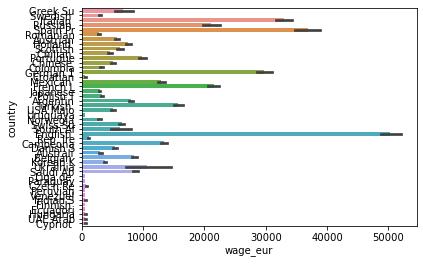

In [39]:
sns.barplot(train.wage_eur, train.country)

In [40]:
train.country.value_counts()

Argentin    3605
English     3372
USA Majo    3293
French L    3109
Spain Pr    3058
Italian     2845
German 1    2803
Turkish     2623
Portugue    2572
Mexican     2506
Holland     2384
Colombia    2319
Belgian     2282
Polish T    2217
Saudi Ab    2192
Swedish     2115
Japanese    2104
Norwegia    2004
Chilian     1791
Danish S    1758
Korean K    1724
Scottish    1669
Austrian    1497
Rep. Ire    1385
Campeona    1375
Swiss Su    1356
Russian     1338
Australi    1261
Chinese     1161
Romanian     813
Greek Su     459
Ecuadori     270
South Af     261
Paraguay     260
Liga de      242
Czech Re     235
Peruvian     226
Uruguaya     202
Venezuel     197
Indian S     187
Ukrainia     176
Finnish       86
Croatian      81
UAE Arab      38
Hungaria      23
Cypriot       18
Name: country, dtype: int64

In [41]:
Argentina.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,3605.000000,3605.000000,3605.000000,3.605000e+03,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.0,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.00000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000
mean,217679.594730,66.117060,71.232732,1.530763e+06,8085.658807,25.523717,178.834397,74.888211,95911.014979,1.0,2020.306241,52.839112,2.837725,2.337864,1.050208,50.265187,45.651595,53.663800,57.945076,43.023856,56.132039,47.440222,43.335645,52.581969,58.356727,64.370874,64.545908,63.115118,62.272122,64.694591,57.22025,64.827462,62.830236,64.154508,47.979196,55.477670,46.565049,50.612483,52.563384,50.352843,45.769209,47.609154,46.178086,16.359501,16.264355,16.282108,16.432732,16.416089,2018.489598,2015.931761,2.557836
std,28681.856249,5.822633,5.378714,2.326745e+06,10120.525259,5.125701,6.657970,6.741747,35774.334739,0.0,2.074227,4.506152,0.585638,0.748376,0.239028,17.404109,18.684663,16.533494,14.799634,16.403401,18.359956,17.234287,16.500142,15.514315,16.508324,14.776161,14.298600,14.930130,8.077216,13.653582,15.59103,12.034180,15.553942,13.060528,19.045884,18.157388,20.469151,18.575039,14.422578,14.902953,20.284738,21.572467,21.116135,17.642696,16.723705,16.504818,17.104213,17.902048,2.244790,2.874030,1.859761
min,48745.000000,49.000000,52.000000,7.000000e+03,500.000000,16.000000,156.000000,54.000000,1013.000000,1.0,2015.000000,3.000000,1.000000,1.000000,1.000000,8.000000,4.000000,10.000000,11.000000,5.000000,5.000000,8.000000,8.000000,11.000000,10.000000,14.000000,11.000000,16.000000,33.000000,11.000000,10.00000,17.000000,14.000000,20.000000,5.000000,13.000000,6.000000,4.000000,10.000000,11.000000,4.000000,7.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000,2000.000000,1.000000
25%,214660.000000,62.000000,67.000000,3.250000e+05,2000.000000,21.000000,174.000000,70.000000,101088.000000,1.0,2019.000000,52.000000,2.000000,2.000000,1.000000,38.000000,30.000000,47.000000,52.000000,31.000000,50.000000,36.000000,33.000000,42.000000,55.000000,56.000000,56.000000,55.000000,57.000000,56.000000,48.00000,57.000000,56.000000,57.000000,33.000000,42.000000,25.000000,40.000000,42.000000,42.000000,25.000000,25.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2017.000000,2014.000000,1.000000
50%,223234.000000,66.000000,71.000000,7.250000e+05,5000.000000,25.000000,179.000000,74.000000,110404.000000,1.0,2021.000000,52.000000,3.000000,2.000000,1.000000,55.000000,48.000000,57.000000,62.000000,45.000000,62.000000,48.000000,42.000000,57.000000,63.000000,67.000000,67.000000,66.000000,63.000000,66.000000,60.00000,65.000000,65.000000,65.000000,52.000000,59.000000,53.000000,56.000000,54.000000,51.000000,50.000000,55.000000,53.000000,11.000000,11.000000,11.000000,11.

In [42]:
Argentina.wage_eur.sum() 

29148800.0

In [43]:
English.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,3372.000000,3372.000000,3372.000000,3.372000e+03,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.0,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000,3372.000000
mean,198339.873072,72.286773,77.799822,9.220414e+06,50261.684460,24.833630,182.374259,76.059312,592.463227,1.0,2020.162811,36.339265,3.053677,2.567319,1.541518,55.792112,50.805457,56.963820,64.934460,48.519276,61.951364,53.456999,47.922894,58.987248,65.075919,67.237841,67.272242,65.715599,68.954033,65.343416,62.586299,66.651542,66.229241,67.289442,52.676453,61.613286,52.185053,55.557829,59.810795,53.969751,50.610617,53.369217,50.737544,17.037367,16.740214,16.510676,16.614769,17.000000,2018.515718,2015.127521,3.388197
std,40529.196688,8.464309,5.747218,1.455302e+07,48111.868042,4.648795,7.055185,7.709386,842.336232,0.0,2.583843,36.470230,0.686196,0.883233,0.763912,19.932944,20.675484,19.075235,15.647221,19.359162,20.029480,19.805737,19.206507,15.761069,17.317618,14.246602,13.843706,14.350140,10.450969,14.044113,16.911393,11.611806,15.832891,12.311582,20.422052,18.183136,22.272300,20.882316,15.535008,16.405559,22.856392,23.503386,23.606602,19.430953,18.551974,18.175996,18.776967,19.936982,2.278331,3.122115,2.322223
min,27.000000,47.000000,55.000000,2.500000e+04,500.000000,16.000000,163.000000,55.000000,1.000000,1.0,2015.000000,3.000000,1.000000,1.000000,1.000000,9.000000,5.000000,10.000000,12.000000,5.000000,5.000000,8.000000,8.000000,11.000000,9.000000,14.000000,16.000000,22.000000,31.000000,21.000000,11.000000,27.000000,14.000000,21.000000,5.000000,12.000000,6.000000,4.000000,11.000000,8.000000,5.000000,9.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000,1997.000000,1.000000
25%,183893.000000,67.000000,74.000000,9.500000e+05,11000.000000,21.000000,178.000000,70.000000,9.000000,1.0,2018.000000,14.000000,3.000000,2.000000,1.000000,44.000000,34.000000,48.000000,59.000000,34.000000,56.000000,39.000000,33.000000,49.000000,59.000000,59.000000,59.000000,57.000000,62.000000,56.000000,52.000000,60.000000,58.000000,60.000000,38.000000,48.000000,30.000000,44.000000,50.000000,43.000000,29.000000,31.000000,26.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2017.000000,2013.000000,2.000000
50%,203487.000000,74.000000,78.000000,4.300000e+06,40000.000000,25.000000,182.000000,75.000000,18.000000,1.0,2020.000000,18.000000,3.000000,3.000000,1.000000,61.000000,54.000000,60.000000,69.000000,50.000000,68.000000,57.000000,48.000000,62.000000,70.000000,69.000000,69.000000,68.000000,71.000000,67.000000,66.000000,68.000000,69.000000,68.000000,58.000000,66.000000,56.000000,61.000000,62.000000,55.000000,55.000000,59.500000,56.500000,11.000000,11.000000,11.000000,11.000000,11.

In [44]:
English.wage_eur.sum()

169482400.0

In [45]:
French.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,3109.000000,3109.000000,3109.000000,3.109000e+03,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.0,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.00000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.00000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000
mean,208748.338694,69.931489,75.633001,4.756137e+06,21549.549694,24.355741,181.368286,75.189450,4506.402702,1.0,2020.092313,46.112255,2.944355,2.440335,1.272113,53.797684,47.89643,55.663236,63.112898,45.836603,59.239305,50.825024,45.534255,56.796719,62.497588,65.292699,65.644259,63.935671,65.546800,64.693792,59.397234,65.506915,63.040528,66.236089,49.832744,58.568350,49.859119,52.738179,56.306529,51.263429,48.506272,51.07816,48.873271,17.205854,17.025732,16.866195,17.234481,17.526214,2018.484400,2015.716629,2.767771
std,37903.410066,6.877546,5.460524,8.591860e+06,25817.648294,4.595776,6.582594,7.080285,20904.728858,0.0,2.550930,44.508173,0.663289,0.823595,0.587239,19.269692,20.52246,18.132346,15.375725,18.548772,19.931414,18.588832,17.786337,16.047123,17.650978,14.481534,14.286332,15.083179,9.285207,14.261175,16.293266,11.626855,16.394518,12.827144,19.758248,18.004367,22.287595,20.364905,15.900702,16.289305,22.700551,23.52390,23.112381,19.696721,18.629214,17.989060,18.807448,19.992253,2.287458,3.106297,1.976725
min,11.000000,50.000000,59.000000,1.000000e+03,500.000000,16.000000,159.000000,54.000000,58.000000,1.0,2015.000000,1.000000,1.000000,1.000000,1.000000,8.000000,3.00000,7.000000,12.000000,5.000000,5.000000,6.000000,7.000000,10.000000,10.000000,15.000000,15.000000,21.000000,30.000000,17.000000,12.000000,26.000000,14.000000,21.000000,5.000000,11.000000,6.000000,2.000000,10.000000,10.000000,5.000000,8.00000,6.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2015.000000,1997.000000,1.000000
25%,193348.000000,65.000000,72.000000,6.750000e+05,5000.000000,21.000000,177.000000,70.000000,68.000000,1.0,2018.000000,18.000000,3.000000,2.000000,1.000000,43.000000,31.00000,49.000000,59.000000,32.000000,54.000000,39.000000,33.000000,48.000000,59.000000,56.000000,58.000000,55.000000,59.000000,56.000000,51.000000,58.000000,55.000000,58.000000,35.000000,47.000000,26.000000,40.000000,47.000000,42.000000,26.000000,27.00000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2017.000000,2014.000000,1.000000
50%,214907.000000,71.000000,76.000000,2.000000e+06,15000.000000,24.000000,182.000000,75.000000,73.000000,1.0,2020.000000,18.000000,3.000000,2.000000,1.000000,59.000000,51.00000,60.000000,67.000000,48.000000,65.000000,53.000000,45.000000,61.000000,68.000000,68.000000,68.000000,67.000000,67.000000,67.000000,62.000000,66.000000,67.000000,68.000000,55.000000,62.000000,57.000000,58.000000,59.000000,53.000000,55.000000,61.00000,58.000000,11.000000,11.000000,11.000000,11.000000,11.000000,2

In [46]:
French.wage_eur.sum()

66997550.0

In [47]:
Spain.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,3058.000000,3058.000000,3058.000000,3.058000e+03,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.0,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000,3058.000000
mean,207000.856769,73.053630,77.897646,9.213260e+06,36844.146501,25.193918,180.719751,74.421517,8642.795618,1.0,2020.243623,48.751799,3.074559,2.572269,1.394375,56.356442,51.432963,55.937541,65.944408,47.528777,60.713865,55.362328,49.142904,59.518640,65.534663,65.615108,65.798888,65.715500,69.459124,65.259320,62.372466,67.011445,64.792675,66.116089,53.643558,59.890451,52.767495,55.981687,59.438195,52.245585,50.162198,52.876063,50.253434,17.771419,17.714519,17.259974,17.535317,17.833878,2018.595814,2015.461740,3.134075
std,33402.460517,7.447674,5.662777,1.412296e+07,58930.693549,4.427883,6.129580,6.243653,28323.486811,0.0,2.550215,22.232119,0.607714,0.893133,0.772944,20.139467,21.455515,19.073958,16.453149,19.240672,20.727074,20.508697,19.203766,16.832853,19.085768,14.210184,13.836506,13.835976,9.674476,13.649898,16.574262,11.756395,15.240527,12.435924,20.930931,18.735459,22.987045,21.376288,16.169518,16.943484,22.619013,24.137473,24.054204,20.250712,19.620173,18.973927,19.635680,20.607471,2.294083,3.210937,2.440595
min,28.000000,49.000000,54.000000,3.000000e+04,500.000000,16.000000,162.000000,56.000000,240.000000,1.0,2015.000000,1.000000,1.000000,1.000000,1.000000,8.000000,5.000000,5.000000,11.000000,5.000000,5.000000,7.000000,5.000000,8.000000,9.000000,14.000000,15.000000,20.000000,34.000000,21.000000,11.000000,30.000000,17.000000,27.000000,4.000000,12.000000,6.000000,3.000000,11.000000,8.000000,5.000000,7.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000,1998.000000,1.000000
25%,190760.000000,68.000000,74.000000,1.300000e+06,9000.000000,22.000000,176.000000,70.000000,449.000000,1.0,2018.000000,45.000000,3.000000,2.000000,1.000000,45.000000,35.000000,47.000000,62.000000,33.000000,53.000000,41.000000,35.000000,51.000000,62.000000,57.000000,57.000000,58.000000,63.000000,57.000000,53.000000,60.000000,56.000000,58.000000,39.000000,47.250000,30.000000,44.000000,48.000000,42.000000,28.000000,29.000000,25.000000,8.000000,9.000000,8.000000,8.000000,8.000000,2017.000000,2014.000000,1.000000
50%,210078.500000,74.000000,78.000000,4.100000e+06,20000.000000,25.000000,180.000000,74.000000,461.000000,1.0,2020.000000,45.000000,3.000000,3.000000,1.000000,61.000000,56.000000,59.000000,70.000000,48.000000,66.000000,59.000000,50.000000,63.000000,71.000000,68.000000,67.000000,67.000000,70.000000,67.000000,65.000000,68.000000,67.000000,67.000000,59.000000,63.000000,59.000000,61.000000,62.000000,54.000000,55.000000,61.000000,56.000000,11.000000,11.000000,11.000000,11.000000

In [48]:
Spain.wage_eur.sum()

112669400.0

In [49]:
Italian.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,2845.000000,2845.000000,2845.000000,2.845000e+03,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.0,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000,2845.000000
mean,198538.803866,72.149385,76.692794,6.978139e+06,32909.420035,25.885062,183.145167,76.733216,25544.347979,1.0,2020.327944,40.052021,2.997188,2.478032,1.497364,54.165905,47.328295,56.976450,63.567311,48.678383,60.543761,53.080844,47.064675,58.171880,64.340246,65.769420,65.797188,64.815114,68.508612,63.571529,62.666081,66.605272,64.550088,67.232337,53.345518,60.263620,52.591213,53.339543,56.675571,51.673111,51.443937,53.559930,51.665026,17.105097,16.638664,16.151142,16.853427,17.313533,2018.554306,2015.588401,2.965905
std,42453.628981,7.236888,5.784804,1.068809e+07,34559.763625,4.865614,6.014196,6.224936,46438.937355,0.0,2.529087,29.636086,0.736333,0.875088,0.706915,20.927204,21.285609,19.014332,16.464623,20.587817,20.562859,20.784097,19.900545,16.866075,18.858145,14.474683,14.688419,14.126273,9.034880,14.544813,17.013798,12.341509,16.704473,12.061484,21.484297,18.822252,23.588207,22.501320,17.197798,17.386137,23.318759,24.446122,24.297802,20.613819,19.648570,17.981325,20.061227,21.202811,2.304742,3.203869,2.328785
min,2.000000,46.000000,52.000000,2.000000e+04,500.000000,16.000000,160.000000,57.000000,39.000000,1.0,2015.000000,1.000000,1.000000,1.000000,1.000000,8.000000,5.000000,9.000000,11.000000,5.000000,5.000000,8.000000,4.000000,11.000000,10.000000,13.000000,15.000000,17.000000,30.000000,16.000000,11.000000,25.000000,15.000000,24.000000,5.000000,11.000000,5.000000,2.000000,11.000000,9.000000,3.000000,9.000000,10.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2015.000000,1993.000000,1.000000
25%,185174.000000,68.000000,73.000000,1.000000e+06,9000.000000,22.000000,180.000000,73.000000,47.000000,1.0,2018.000000,27.000000,3.000000,2.000000,1.000000,39.000000,29.000000,50.000000,58.000000,33.000000,53.000000,38.000000,32.000000,48.000000,59.000000,57.000000,57.000000,56.000000,63.000000,55.000000,54.000000,59.000000,56.000000,60.000000,37.000000,48.000000,26.000000,34.000000,45.000000,40.000000,26.000000,28.000000,25.000000,7.000000,7.000000,7.000000,7.000000,7.000000,2017.000000,2014.000000,1.000000
50%,205531.000000,73.000000,77.000000,3.000000e+06,20000.000000,25.000000,183.000000,77.000000,189.000000,1.0,2021.000000,27.000000,3.000000,2.000000,1.000000,60.000000,50.000000,61.000000,68.000000,51.000000,67.000000,58.000000,48.000000,62.000000,70.000000,68.000000,68.000000,67.000000,70.000000,65.000000,67.000000,68.000000,68.000000,68.000000,60.000000,66.000000,61.000000,60.000000,60.000000,53.000000,59.000000,64.000000,62.000000,10.000000,10.000000,10.000000,10.00000

In [50]:
Italian.wage_eur.sum()

93627300.0

In [51]:
German.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,2803.000000,2803.000000,2803.000000,2.803000e+03,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.0,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.00000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000,2803.000000
mean,206988.145915,71.745986,77.292187,7.058591e+06,29744.452372,24.441313,183.515162,78.173386,16538.065644,1.0,2020.066001,34.727078,3.141277,2.481984,1.451302,54.927934,49.459151,56.439529,64.481984,48.277560,60.896539,52.477346,46.440243,57.667142,63.924724,66.173386,66.793792,65.530146,69.031752,64.210846,62.571174,66.871209,64.95041,67.967535,51.327506,60.379237,51.281127,53.980021,58.001070,51.230467,49.829825,52.400999,49.816268,17.403139,16.919729,16.631466,17.027471,17.544773,2018.512308,2015.523368,2.988940
std,33251.991834,7.432906,5.258272,1.077316e+07,32014.101195,4.281540,6.478100,7.006516,37528.407169,0.0,2.576647,34.702561,0.681156,0.831620,0.673794,19.821702,21.210159,19.249317,15.771407,19.913213,20.349480,19.925408,18.532788,16.038614,18.041541,14.902440,14.275144,14.678401,9.977601,14.993579,16.483013,11.300049,16.33002,12.275799,20.470582,17.647895,22.616220,21.325097,15.309524,16.553367,23.103033,23.674717,23.737624,19.593919,18.540857,17.650549,18.740945,20.069234,2.283004,3.161443,2.249646
min,1611.000000,50.000000,56.000000,2.500000e+04,500.000000,17.000000,165.000000,57.000000,21.000000,1.0,2015.000000,1.000000,1.000000,1.000000,1.000000,7.000000,4.000000,8.000000,14.000000,4.000000,5.000000,7.000000,7.000000,10.000000,10.000000,15.000000,16.000000,20.000000,33.000000,21.000000,14.000000,22.000000,14.00000,30.000000,5.000000,15.000000,3.000000,3.000000,6.000000,10.000000,5.000000,8.000000,8.000000,4.000000,3.000000,5.000000,3.000000,5.000000,2015.000000,2002.000000,1.000000
25%,190666.000000,67.000000,74.000000,1.000000e+06,8000.000000,21.000000,179.000000,73.000000,31.000000,1.0,2018.000000,21.000000,3.000000,2.000000,1.000000,43.000000,33.000000,47.000000,61.000000,33.000000,56.000000,39.000000,33.000000,49.000000,60.000000,58.000000,60.000000,56.000000,63.000000,55.000000,53.000000,60.000000,57.00000,62.000000,35.000000,48.000000,29.000000,41.000000,48.000000,41.000000,27.000000,30.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2017.000000,2014.000000,1.000000
50%,208700.000000,73.000000,77.000000,3.400000e+06,20000.000000,24.000000,184.000000,78.000000,166.000000,1.0,2020.000000,21.000000,3.000000,2.000000,1.000000,60.000000,53.000000,59.000000,69.000000,50.000000,67.000000,56.000000,46.000000,62.000000,70.000000,68.000000,68.000000,68.000000,71.000000,66.000000,66.000000,68.000000,68.00000,69.000000,56.000000,64.000000,56.000000,59.000000,60.000000,52.000000,55.000000,59.000000,56.000000,11.000000,11.000000,11.000000,11.000000,11

In [52]:
German.wage_eur.sum()

83373700.0

In [53]:
Turkish.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,2623.000000,2623.000000,2623.000000,2.623000e+03,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.0,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.00000,2623.000000,2623.000000,2623.000000,2623.000000,2623.00000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000,2623.000000
mean,203363.656881,68.100648,71.606176,2.198401e+06,15765.935951,26.420511,181.496759,75.651163,69484.949676,1.0,2019.755242,55.130004,2.852459,2.409074,1.176515,52.857034,47.371331,54.589401,60.497522,45.941289,58.25467,50.490660,46.383912,55.487991,60.133816,64.84979,65.229508,63.595883,64.347312,63.780023,60.473504,65.084636,63.172703,65.748380,50.782310,58.469310,48.316813,52.243233,54.682806,51.550896,46.873427,49.513153,47.195578,17.304232,17.008006,16.717118,16.972932,17.340450,2018.614182,2016.256576,2.357606
std,37857.223981,6.243331,4.980365,2.931397e+06,18722.745754,4.376502,6.476082,6.584075,50000.039272,0.0,2.414903,32.972081,0.808494,0.803326,0.460190,18.860556,19.731786,18.084204,15.459770,18.632634,19.47603,19.483251,18.236375,15.892989,17.587181,14.69438,14.434362,14.996308,8.247844,14.589842,16.930759,12.277823,16.116268,12.497169,20.330138,17.353828,21.034494,20.034132,14.357829,16.590286,21.555120,22.322777,21.762278,18.750410,17.686942,17.246675,18.122802,19.364336,2.294951,2.960091,1.866703
min,80.000000,48.000000,50.000000,2.000000e+04,500.000000,17.000000,164.000000,55.000000,325.000000,1.0,2015.000000,1.000000,1.000000,1.000000,1.000000,9.000000,3.000000,9.000000,12.000000,3.000000,5.00000,10.000000,7.000000,11.000000,5.000000,15.00000,15.000000,19.000000,30.000000,21.000000,10.000000,21.000000,16.000000,24.000000,5.000000,15.000000,4.000000,4.000000,11.000000,9.000000,4.000000,10.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000,2002.000000,1.000000
25%,185185.000000,64.000000,68.000000,5.000000e+05,4000.000000,23.000000,177.000000,71.000000,741.000000,1.0,2018.000000,48.000000,2.000000,2.000000,1.000000,41.000000,32.000000,48.000000,58.000000,32.000000,53.00000,37.000000,35.000000,48.000000,57.000000,57.00000,58.000000,55.000000,59.500000,55.000000,51.000000,58.000000,56.000000,58.000000,36.000000,48.000000,27.000000,40.000000,45.000000,43.000000,25.000000,28.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2017.000000,2014.000000,1.000000
50%,205364.000000,69.000000,72.000000,1.100000e+06,9000.000000,27.000000,181.000000,75.000000,101025.000000,1.0,2020.000000,48.000000,3.000000,2.000000,1.000000,58.000000,51.000000,58.000000,65.000000,48.000000,65.00000,53.000000,46.000000,60.000000,65.000000,67.00000,68.000000,66.000000,65.000000,66.000000,64.000000,66.000000,67.000000,66.000000,57.000000,62.000000,54.000000,59.000000,58.000000,53.000000,52.000000,58.000000,55.000000,11.000000,12.000000,11.000000,11.000000,11.00

In [54]:
Turkish.wage_eur.sum()

41354050.0

In [55]:
Mexican.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,2506.000000,2506.000000,2506.000000,2.506000e+03,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.0,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000,2506.000000
mean,209290.607741,66.754190,70.998005,1.756564e+06,12977.513966,25.715483,177.522346,73.225060,59805.145251,1.0,2020.884677,74.618915,2.954509,2.327614,1.066241,52.025539,47.398244,54.058260,59.921389,45.268156,57.169992,49.839984,45.512370,54.979649,59.421788,65.444533,65.308061,64.694733,62.325219,65.725858,59.323623,65.942937,63.221868,64.397845,49.926177,54.576217,47.320830,50.903033,54.153631,52.849561,46.067438,47.944533,46.620112,16.702314,16.633679,16.564645,16.642059,16.816441,2018.523943,2015.685954,2.837989
std,29411.850645,6.052287,4.850705,2.312357e+06,14248.165977,4.695270,6.804051,7.204652,53719.420358,0.0,1.989159,14.365420,0.632081,0.768135,0.270288,17.467488,18.790669,17.015614,14.081110,17.258072,18.366893,17.817111,16.703067,14.521949,16.295122,14.408979,14.337842,13.995258,8.182108,13.349750,15.207448,11.745043,16.276241,13.021713,18.932988,17.619237,20.032947,18.888827,13.564893,15.498043,19.932958,20.981860,20.633639,18.095400,17.230453,17.060957,17.530879,18.264956,2.288482,3.458557,2.437254
min,28130.000000,48.000000,54.000000,1.500000e+04,500.000000,17.000000,155.000000,51.000000,1028.000000,1.0,2015.000000,14.000000,1.000000,1.000000,1.000000,9.000000,5.000000,8.000000,12.000000,5.000000,5.000000,10.000000,9.000000,12.000000,10.000000,16.000000,15.000000,21.000000,30.000000,21.000000,4.000000,28.000000,16.000000,12.000000,5.000000,11.000000,6.000000,4.000000,13.000000,10.000000,5.000000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2015.000000,1991.000000,1.000000
25%,187238.000000,62.000000,68.000000,4.000000e+05,3000.000000,22.000000,172.000000,68.000000,1880.000000,1.0,2020.000000,58.000000,3.000000,2.000000,1.000000,42.000000,33.000000,48.000000,57.000000,33.000000,52.000000,39.000000,35.000000,49.000000,56.000000,58.000000,58.000000,57.000000,57.000000,58.000000,52.000000,59.000000,55.000000,57.000000,38.000000,42.000000,28.000000,40.000000,46.000000,45.000000,26.000000,28.000000,26.000000,8.000000,9.000000,8.000000,8.000000,8.000000,2017.000000,2014.000000,1.000000
50%,213589.000000,67.000000,71.000000,8.250000e+05,7000.000000,26.000000,178.000000,73.000000,101114.000000,1.0,2021.000000,83.000000,3.000000,2.000000,1.000000,58.000000,50.000000,57.000000,64.000000,48.000000,63.000000,53.000000,45.000000,59.000000,64.000000,68.000000,68.000000,66.000000,63.000000,67.000000,63.000000,67.000000,67.000000,66.000000,55.000000,58.000000,53.000000,56.000000,56.000000,56.000000,50.000000,54.000000,54.000000,11.000000,11.000000,11.00

In [56]:
Mexican.wage_eur.sum()

32521650.0

In [57]:
Portuguese.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,2572.000000,2572.000000,2572.000000,2.572000e+03,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.0,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.000000,2572.00000,2572.000000,2572.000000
mean,213562.736003,69.272939,73.684681,3.126054e+06,9849.494557,25.081260,181.875194,75.177294,13991.258554,1.0,2020.072706,54.718118,2.850311,2.421462,1.103033,51.510109,46.877916,54.811042,60.631026,45.826205,59.088647,50.779160,44.603810,53.491446,61.574650,64.909020,65.083204,64.065708,66.580871,63.140358,61.653577,65.261275,63.578149,66.256610,49.527605,59.450622,48.388025,52.445568,54.683904,51.211120,47.094090,49.799767,47.353033,17.068429,16.701011,16.358087,16.781104,17.187403,2018.48717,2016.171073,2.316096
std,38855.644088,5.263511,5.134264,4.783557e+06,14528.826070,4.049385,6.633101,7.038516,34050.377049,0.0,2.599061,29.972726,0.649138,0.803806,0.389325,18.597068,19.553193,17.497304,14.561620,17.795145,19.000868,18.802589,17.462114,15.674350,16.890208,14.934561,14.616133,14.575197,7.509055,14.602211,15.818328,12.199694,15.556215,12.754429,19.597953,17.859392,21.741299,20.018169,14.034602,16.175385,21.855945,22.622035,21.907601,19.005577,17.962092,17.210790,18.451275,19.189810,2.28745,2.825588,1.736426
min,2492.000000,56.000000,59.000000,3.500000e+04,500.000000,17.000000,164.000000,55.000000,234.000000,1.0,2015.000000,3.000000,1.000000,1.000000,1.000000,9.000000,4.000000,8.000000,11.000000,5.000000,5.000000,8.000000,8.000000,11.000000,8.000000,15.000000,15.000000,18.000000,34.000000,20.000000,9.000000,30.000000,17.000000,28.000000,4.000000,12.000000,6.000000,2.000000,10.000000,9.000000,5.000000,8.000000,8.000000,2.000000,3.000000,2.000000,1.000000,3.000000,2015.00000,1999.000000,1.000000
25%,201331.250000,65.000000,70.000000,7.000000e+05,3000.000000,22.000000,177.000000,70.000000,666.000000,1.0,2018.000000,38.000000,2.000000,2.000000,1.000000,38.000000,31.000000,47.000000,56.000000,33.000000,53.000000,38.000000,33.000000,43.000000,59.000000,56.000000,56.000000,56.000000,62.000000,55.000000,52.000000,58.000000,56.000000,59.000000,34.000000,47.000000,25.000000,39.000000,45.000000,42.000000,25.000000,27.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2016.00000,2014.000000,1.000000
50%,219878.500000,69.000000,73.000000,1.300000e+06,6000.000000,25.000000,182.000000,75.000000,1891.000000,1.0,2020.000000,45.000000,3.000000,2.000000,1.000000,56.000000,49.000000,58.000000,64.000000,48.000000,65.000000,53.000000,43.000000,57.000000,67.000000,68.000000,68.000000,66.000000,67.000000,65.000000,66.000000,66.000000,67.000000,68.000000,55.000000,64.000000,56.000000,59.000000,57.000000,52.000000,53.000000,59.000000,55.000000,11.000000,11.000000,11.000000,11.000000,11

In [58]:
Portuguese.wage_eur.sum()

25332900.0

In [59]:
Holland.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,2384.000000,2384.000000,2384.000000,2.384000e+03,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.0,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.00000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000,2384.000000
mean,215239.419883,66.858221,72.845218,2.083024e+06,7614.471477,23.448826,182.175336,75.315856,17367.645554,1.0,2019.537752,42.336409,3.012584,2.352349,1.070889,50.264262,45.608221,51.611158,59.625000,44.197987,56.781460,49.111997,43.773909,54.473993,60.236997,64.417366,64.198406,63.161493,62.460151,63.048658,58.433725,64.850671,61.823406,65.110738,47.794883,55.174916,46.13255,49.397232,54.263423,48.935822,45.523909,47.081795,45.533977,17.871225,17.665268,17.535235,17.588507,18.008389,2018.510067,2015.965185,2.544883
std,32952.695363,5.265988,5.054129,3.774573e+06,11247.213591,4.196183,6.760538,6.934293,36500.881691,0.0,2.486945,34.543885,0.696379,0.798137,0.293316,18.276511,19.491308,18.045712,14.410544,17.970491,19.113781,19.205660,17.666410,15.048451,16.379868,15.691846,15.809015,15.148514,7.519180,14.141933,15.394321,12.192518,16.278919,11.993192,19.127734,17.028796,20.91136,19.367623,14.223127,15.017058,20.651380,21.373475,21.012947,19.409662,18.415119,18.199356,18.504917,19.536121,2.263557,2.819668,1.742702
min,2147.000000,54.000000,59.000000,2.500000e+04,500.000000,16.000000,163.000000,55.000000,245.000000,1.0,2015.000000,1.000000,1.000000,1.000000,1.000000,8.000000,4.000000,6.000000,12.000000,4.000000,6.000000,9.000000,7.000000,11.000000,10.000000,16.000000,15.000000,19.000000,30.000000,20.000000,11.000000,29.000000,14.000000,28.000000,5.000000,13.000000,4.00000,4.000000,13.000000,9.000000,5.000000,10.000000,8.000000,3.000000,5.000000,3.000000,3.000000,5.000000,2015.000000,2005.000000,1.000000
25%,202184.500000,63.000000,69.000000,5.000000e+05,2000.000000,20.000000,177.000000,70.000000,650.000000,1.0,2018.000000,34.000000,3.000000,2.000000,1.000000,39.000000,30.000000,44.000000,56.000000,31.000000,52.000000,35.000000,32.000000,45.000000,58.000000,55.000000,55.000000,55.000000,58.000000,55.000000,49.000000,58.000000,54.000000,57.000000,33.000000,43.000000,25.00000,37.000000,44.000000,41.000000,25.000000,25.000000,24.000000,8.000000,9.000000,8.000000,8.000000,9.000000,2017.000000,2014.000000,1.000000
50%,220663.500000,67.000000,73.000000,9.000000e+05,4000.000000,23.000000,182.000000,75.000000,1907.000000,1.0,2020.000000,34.000000,3.000000,2.000000,1.000000,56.000000,49.000000,56.000000,64.000000,46.000000,63.000000,51.000000,43.000000,59.000000,65.000000,67.000000,67.000000,66.000000,63.000000,65.000000,62.000000,66.000000,65.000000,66.000000,52.000000,59.000000,53.00000,55.000000,56.000000,50.000000,51.000000,55.000000,53.000000,11.000000,11.000000,11.000000,11.000000,

In [60]:
Holland.wage_eur.sum()

18152900.0

In [61]:
USA.describe()

,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,league_level,club_contract_valid_until,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,year,year_joined,seniority
count,3293.000000,3293.000000,3293.000000,3.293000e+03,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.0,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000,3293.000000
mean,209878.111449,65.520802,69.864258,1.394853e+06,5101.305800,25.851503,180.835105,76.254783,62404.422108,1.0,2020.232918,79.518676,2.862132,2.345278,1.074704,47.671424,45.396295,52.044336,58.872760,43.657455,55.239903,48.635287,42.587610,52.808078,57.726997,65.026420,65.056180,63.386274,61.839964,63.514728,57.696629,65.765563,63.759490,65.891285,46.643790,60.088673,47.262071,50.200121,52.941695,48.899787,46.983905,48.000000,45.532341,16.974491,16.662618,16.757364,16.629821,16.979046,2018.786821,2016.267234,2.519587
std,36910.770577,6.076513,5.077238,2.305998e+06,7769.668031,4.463991,7.253890,7.882707,54860.635820,0.0,2.065480,30.265352,0.750336,0.772087,0.330517,17.506868,18.666933,16.724317,13.983475,17.317225,18.417516,18.903356,17.582594,14.396325,16.447083,14.813715,14.873429,15.337601,8.358948,14.721003,15.876057,11.376403,15.517007,11.925461,18.550112,16.303863,19.211055,19.176541,14.093646,15.493119,19.808026,20.226407,19.815398,17.746167,16.890309,17.094380,17.158557,18.045790,2.297203,2.942690,1.851733
min,330.000000,44.000000,53.000000,5.000000e+03,500.000000,16.000000,157.000000,55.000000,687.000000,1.0,2015.000000,1.000000,1.000000,1.000000,1.000000,6.000000,4.000000,8.000000,11.000000,4.000000,5.000000,6.000000,7.000000,13.000000,9.000000,15.000000,15.000000,16.000000,24.000000,19.000000,10.000000,29.000000,12.000000,28.000000,5.000000,13.000000,6.000000,4.000000,9.000000,9.000000,5.000000,7.000000,6.000000,3.000000,3.000000,1.000000,3.000000,2.000000,2015.000000,2005.000000,1.000000
25%,194163.000000,62.000000,66.000000,3.250000e+05,2000.000000,23.000000,175.000000,70.000000,694.000000,1.0,2019.000000,57.000000,2.000000,2.000000,1.000000,35.000000,30.000000,45.000000,55.000000,30.000000,49.000000,34.000000,29.000000,44.000000,55.000000,56.000000,56.000000,54.000000,57.000000,55.000000,48.000000,59.000000,56.000000,59.000000,32.000000,51.000000,29.000000,39.000000,44.000000,38.000000,30.000000,29.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2017.000000,2014.000000,1.000000
50%,213536.000000,66.000000,70.000000,6.500000e+05,3000.000000,25.000000,180.000000,75.000000,111065.000000,1.0,2020.000000,95.000000,3.000000,2.000000,1.000000,52.000000,49.000000,56.000000,63.000000,45.000000,61.000000,51.000000,41.000000,56.000000,63.000000,68.000000,68.000000,66.000000,63.000000,66.000000,61.000000,67.000000,67.000000,67.000000,51.000000,64.000000,53.000000,55.000000,55.000000,51.000000,54.000000,56.000000,53.000000,11.000000,11.000000,11.000000,11.0000

In [62]:
USA.wage_eur.sum()

16798600.0

In [63]:
train

,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,position,club_joined,club_contract_valid_until,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,year,year_joined,seniority,country
114222,189207,J. Durmaz,"LM, RM",70,73,1600000.0,35000.0,26,180,70,280.0,Olympiacos CFP,Greek Super League,1.0,SUB,Substitute,2014-08-22,2018.0,46,Sweden,Left,3,4,1,Medium/Low,83.0,68.0,69.0,75.0,28.0,57.0,70,60,22,69,70,75,75,69,67,73,82,84,84,56,81,82,53,73,41,78,80,22,59,68,45,21,41,30,8,14,9,12,15,0,2016,2014,2,Greek Su
102434,189295,J. Sudić,CB,65,68,550000.0,2000.0,25,193,87,711.0,BK Häcken,Swedish Allsvenskan,1.0,LCB,Left Centre Back,2015-01-09,2018.0,46,Sweden,Right,2,2,1,Medium/Medium,54.0,26.0,44.0,45.0,63.0,72.0,26,17,62,56,23,37,22,27,51,55,50,57,41,58,54,51,42,47,84,25,81,65,24,43,23,65,61,60,9,10,13,12,9,0,2017,2015,2,Swedish
94178,197231,K. Babacar,ST,76,81,7000000.0,60000.0,23,185,76,110374.0,Fiorentina,Italian Serie A,1.0,SUB,Substitute,2010-01-14,2019.0,136,Senegal,Right,4,3,2,Medium/Medium,75.0,76.0,55.0,73.0,28.0,71.0,50,80,74,64,76,72,64,60,46,76,71,78,72,70,60,82,76,69,77,63,58,20,77,48,70,20,26,24,12,6,10,8,14,0,2017,2010,7,Italian
75884,207439,L. Paredes,"CDM, CM",77,84,10500000.0,50000.0,23,180,75,100769.0,Zenit St. Petersburg,Russian Premier League,1.0,LCM,Left (off-centre) Centre Midfield,2017-07-01,2021.0,52,Argentina,Right,4,4,2,Medium/Medium,72.0,66.0,80.0,78.0,69.0,73.0,74,55,60,83,73,77,79,76,80,82,75,69,77,74,77,80,61,79,69,77,79,72,64,82,57,64,75,72,9,14,6,9,10,0,2018,2017,1,Russian
20033,210463,D. Machís,"LM, ST",78,78,15000000.0,29000.0,27,174,74,110832.0,Granada CF,Spain Primera Division,1.0,LM,Left Midfield,2019-07-28,2021.0,61,Venezuela,Right,4,4,1,High/Medium,86.0,77.0,74.0,80.0,38.0,67.0,79,76,51,74,57,79,65,73,71,78,88,85,91,68,93,84,81,73,62,79,70,38,75,72,72,40,35,24,8,8,10,13,10,0,2021,2019,2,Spain Pr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36822,246935,M. Kusu,CDM,55,69,275000.0,500.0,18,178,68,702.0,IFK Norrköping,Swedish Allsvenskan,1.0,RES,Reserves,2019-01-18,2023.0,46,Sweden,Right,3,2,1,Medium/Medium,65.0,37.0,49.0,52.0,49.0,66.0,36,32,46,57,30,48,35,39,54,53,63,66,64,48,71,47,71,64,69,35,58,51,43,48,44,48,50,52,7,10,11,8,8,0,2021,2019,2,Swedish
122577,221937,G. Trifiro,"CAM, CM",60,62,230000.0,3000.0,25,172,74,111396.0,Central Coast Mariners,Australian Hyundai A-League,1.0,RCM,Right (off-centre) Centre Midfield,2014-02-04,2017.0,195,Australia,Right,3,2,1,High/Medium,65.0,58.0,60.0,61.0,47.0,55.0,47,57,45,62,42,61,68,69,61,61,64,66,67,47,63,62,64,59,58,60,42,49,56,65,61,46,46,47,7,8,13,16,15,0,2016,2014,2,Australi
124508,228669,S. Gómez,ST,56,67,160000.0,4000.0,19,185,83,15029.0,Universidad de Chile,Chilian Campeonato Nacional,1.0,RES,Reserves,2015-05-03,2021.0,55,Chile,Right,3,2,1,High/Low,55.0,57.0,36.0,51.0,20.0,65.0,25,59,65,42,45,49,39,32,23,50,54,55,57,54,54,57,80,64,74,53,41,12,59,45,59,

In [64]:
train

,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,position,club_joined,club_contract_valid_until,nationality_id,nationality_name,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,year,year_joined,seniority,country
114222,189207,J. Durmaz,"LM, RM",70,73,1600000.0,35000.0,26,180,70,280.0,Olympiacos CFP,Greek Super League,1.0,SUB,Substitute,2014-08-22,2018.0,46,Sweden,Left,3,4,1,Medium/Low,83.0,68.0,69.0,75.0,28.0,57.0,70,60,22,69,70,75,75,69,67,73,82,84,84,56,81,82,53,73,41,78,80,22,59,68,45,21,41,30,8,14,9,12,15,0,2016,2014,2,Greek Su
102434,189295,J. Sudić,CB,65,68,550000.0,2000.0,25,193,87,711.0,BK Häcken,Swedish Allsvenskan,1.0,LCB,Left Centre Back,2015-01-09,2018.0,46,Sweden,Right,2,2,1,Medium/Medium,54.0,26.0,44.0,45.0,63.0,72.0,26,17,62,56,23,37,22,27,51,55,50,57,41,58,54,51,42,47,84,25,81,65,24,43,23,65,61,60,9,10,13,12,9,0,2017,2015,2,Swedish
94178,197231,K. Babacar,ST,76,81,7000000.0,60000.0,23,185,76,110374.0,Fiorentina,Italian Serie A,1.0,SUB,Substitute,2010-01-14,2019.0,136,Senegal,Right,4,3,2,Medium/Medium,75.0,76.0,55.0,73.0,28.0,71.0,50,80,74,64,76,72,64,60,46,76,71,78,72,70,60,82,76,69,77,63,58,20,77,48,70,20,26,24,12,6,10,8,14,0,2017,2010,7,Italian
75884,207439,L. Paredes,"CDM, CM",77,84,10500000.0,50000.0,23,180,75,100769.0,Zenit St. Petersburg,Russian Premier League,1.0,LCM,Left (off-centre) Centre Midfield,2017-07-01,2021.0,52,Argentina,Right,4,4,2,Medium/Medium,72.0,66.0,80.0,78.0,69.0,73.0,74,55,60,83,73,77,79,76,80,82,75,69,77,74,77,80,61,79,69,77,79,72,64,82,57,64,75,72,9,14,6,9,10,0,2018,2017,1,Russian
20033,210463,D. Machís,"LM, ST",78,78,15000000.0,29000.0,27,174,74,110832.0,Granada CF,Spain Primera Division,1.0,LM,Left Midfield,2019-07-28,2021.0,61,Venezuela,Right,4,4,1,High/Medium,86.0,77.0,74.0,80.0,38.0,67.0,79,76,51,74,57,79,65,73,71,78,88,85,91,68,93,84,81,73,62,79,70,38,75,72,72,40,35,24,8,8,10,13,10,0,2021,2019,2,Spain Pr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36822,246935,M. Kusu,CDM,55,69,275000.0,500.0,18,178,68,702.0,IFK Norrköping,Swedish Allsvenskan,1.0,RES,Reserves,2019-01-18,2023.0,46,Sweden,Right,3,2,1,Medium/Medium,65.0,37.0,49.0,52.0,49.0,66.0,36,32,46,57,30,48,35,39,54,53,63,66,64,48,71,47,71,64,69,35,58,51,43,48,44,48,50,52,7,10,11,8,8,0,2021,2019,2,Swedish
122577,221937,G. Trifiro,"CAM, CM",60,62,230000.0,3000.0,25,172,74,111396.0,Central Coast Mariners,Australian Hyundai A-League,1.0,RCM,Right (off-centre) Centre Midfield,2014-02-04,2017.0,195,Australia,Right,3,2,1,High/Medium,65.0,58.0,60.0,61.0,47.0,55.0,47,57,45,62,42,61,68,69,61,61,64,66,67,47,63,62,64,59,58,60,42,49,56,65,61,46,46,47,7,8,13,16,15,0,2016,2014,2,Australi
124508,228669,S. Gómez,ST,56,67,160000.0,4000.0,19,185,83,15029.0,Universidad de Chile,Chilian Campeonato Nacional,1.0,RES,Reserves,2015-05-03,2021.0,55,Chile,Right,3,2,1,High/Low,55.0,57.0,36.0,51.0,20.0,65.0,25,59,65,42,45,49,39,32,23,50,54,55,57,54,54,57,80,64,74,53,41,12,59,45,59,

In [65]:
import plotly.express as px

In [ ]:
fig = px.box(train, x="position", y="wage_eur", points="all", animation_frame='year', color="country",
                   hover_name="country")
fig.update_xaxes(categoryorder = 'mean ascending')
fig.update_layout(title_text='Wage Per Position', title_x=0.5)
fig.show()


In [ ]:
fig = px.box(train, x="league_name", y="wage_eur", points="all", animation_frame='year', color="country",
                   hover_name="country")
fig.update_xaxes(categoryorder = 'mean ascending')
fig.update_layout(title_text='Wage Per League', title_x=0.5)
fig.show()

In [ ]:
fig = px.box(train, x="club_name", y="wage_eur", points="all", animation_frame='year', color="country",
                   hover_name="country")
fig.update_xaxes(categoryorder = 'mean ascending')
fig.update_layout(title_text='Wage Per Club', title_x=0.5)
fig.show()


In [ ]:
# df = px.data.gapminder().query("year").query("fifa_total_player_budget")
#train.loc[train['wage_eur'] < 2.6, 'country'] = 'top' # Represent only large countries
fig = px.pie(train, values='wage_eur', names='league_name', title='LEAGUE')
fig.show()

In [ ]:
fig = px.box(train, x="age", y="wage_eur", points="all", animation_frame='year', color="country",
                   hover_name="country")
fig.update_xaxes(categoryorder = 'mean ascending')
fig.update_layout(title_text='WAGE & AGE', title_x=0.5)
fig.show()


In [ ]:
fig = px.box(train, x="club_joined", y="wage_eur", points="all", animation_frame='year', color="country",
                   hover_name="country")
fig.update_xaxes(categoryorder = 'mean ascending')
fig.update_layout(title_text='Wage Per Position', title_x=0.5)
fig.show()


In [ ]:
train['year_joined'] = train.club_joined.str[:4]
train.year_joined

In [ ]:
train

In [ ]:
train.seniority.value_counts()

In [ ]:
popular1 = df[df.international_reputation == 5]
popular2 = df[df.international_reputation == 4]
popular3 = df[df.international_reputation == 3]
popular4 = df[df.international_reputation == 2]
popular5 = df[df.international_reputation == 1]

In [ ]:
popular.wage_eur.value_counts()

In [ ]:
popular2.wage_eur.value_counts()

In [ ]:
popular3.wage_eur.value_counts()

In [ ]:
popular3

In [ ]:
popular4

In [ ]:
popular5[popular5.year == 2022]

In [ ]:
df[df.wage_eur < 4000]

In [ ]:
train_list = outliers[outliers < 2]
train_list

In [ ]:
df.wage_eur.max()

In [ ]:
df.wage_eur.med()

In [ ]:
df.wage_eur.min()